In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from river import compose, preprocessing, metrics, datasets, anomaly
from deep_river.anomaly import RollingAutoencoder, Autoencoder
from torch import nn, manual_seed
import torch
from tqdm import tqdm
import itertools
from sklearn.decomposition import PCA
from deep_river.utils.tensor_conversion import (df2tensor, dict2tensor,
                                                 deque2rolling_tensor)

In [31]:
### SET YOUR PARAMETERS

dataset = 'raiway' #change the dataset to use (raiway/fan/pump/valve)
module = 'LSTMAutoencoderSutskever' #change the LSTM component (LSTMAutoencoderSutskever/LSTMAutoencoderSrivastava/LSTMAutoencoderCho)

quantile_filter = 1 #0 for Classic Autoencoder, 1 for Quantile Filter Autoencoder

In [32]:
# import Rai Way data

if dataset == 'raiway':
    
    test_data = np.load('data/raiway/80_20/ei-tesi---rai-way-spectrogram-X_testing.npy')
    train_data = np.load('data/raiway/80_20/ei-tesi---rai-way-spectrogram-X_training.npy')
    train_labels = np.load('data/raiway/80_20/ei-tesi---rai-way-spectrogram-y_training.npy')
    test_labels = np.load('data/raiway/80_20/ei-tesi---rai-way-spectrogram-y_testing.npy')

    modello = keras.models.load_model('data/raiway/80_20/model.h5',compile=False)
    modello.compile()

    window = 8

In [33]:
# import fan data

if dataset == 'fan':

    test_data = np.load('data/mimii/fan/ei-industry-4.0---predictivemaintenance---fan-spectrogram-X_testing.npy')
    train_data = np.load('data/mimii/fan/ei-industry-4.0---predictivemaintenance---fan-spectrogram-X_training.npy')
    train_labels = np.load('data/mimii/fan/ei-industry-4.0---predictivemaintenance---fan-spectrogram-y_training.npy')
    test_labels = np.load('data/mimii/fan/ei-industry-4.0---predictivemaintenance---fan-spectrogram-y_testing.npy')

    modello = keras.models.load_model('data/mimii/fan/model.h5')

    window = 9

In [34]:
# import pump data

if dataset == 'pump':

    test_data = np.load('data/mimii/pump/ei-industry-4.0---predictive-maintenance---pump-mfe-X.npy')
    train_data = np.load('data/mimii/pump/ei-industry-4.0---predictive-maintenance---pump-mfe-X-2.npy')
    train_labels = np.load('data/mimii/pump/ei-industry-4.0---predictive-maintenance---pump-mfe-y.npy')
    test_labels = np.load('data/mimii/pump/ei-industry-4.0---predictive-maintenance---pump-mfe-y-2.npy')

    modello = keras.models.load_model('data/mimii/pump/model.h5')
    window = 9

In [35]:
# import valve data

if dataset == 'valve':

    test_data = np.load('data/mimii/valve/ei-industry-4.0---predictive-maintenance---valve-spectrogram-X.npy')
    train_data = np.load('data/mimii/valve/ei-industry-4.0---predictive-maintenance---valve-spectrogram-X-2.npy')
    train_labels = np.load('data/mimii/valve/ei-industry-4.0---predictive-maintenance---valve-spectrogram-y-2.npy')
    test_labels = np.load('data/mimii/valve/ei-industry-4.0---predictive-maintenance---valve-spectrogram-y.npy')

    modello = keras.models.load_model('data/mimii/valve/model.h5')
    window = 9

In [36]:
# rescale labels

train_labels[train_labels[:,0]==2,0] = 0
test_labels[test_labels[:,0]==2,0] = 0

In [37]:
# filter normal data in train dataset

normal_train_idx = train_labels[:,0] == 0
train_data_normal = train_data[normal_train_idx,]
train_labels_normal = train_labels[normal_train_idx,]

In [38]:
# import model from Edge Impulse and visualize it

modello.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 199, 65)           0         
                                                                 
 conv1d (Conv1D)             (None, 199, 8)            1568      
                                                                 
 max_pooling1d (MaxPooling1  (None, 100, 8)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 8)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 16)           400       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 50, 16)            0         
 g1D)                                                   

In [39]:
# feature extraction from dense layer

feature_extractor = keras.Model(
   inputs=modello.inputs,
   outputs=modello.get_layer(name="dense").output)

features = feature_extractor.predict(train_data)
#features_df = pd.DataFrame(features)

features_test = feature_extractor.predict(test_data)
#features_df_test = pd.DataFrame(features_test)

163/163 [==============================] - 1s 6ms/step


In [40]:
class LSTMAutoencoderSrivastava(nn.Module):
    def __init__(self, n_features, hidden_size=20, n_layers=1, batch_first=False):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_first = batch_first
        self.time_axis = 1 if batch_first else 0
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=batch_first,
        )
        self.decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=n_features,
            num_layers=n_layers,
            batch_first=batch_first,
        )

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        h = h[-1].view(1, -1)
        x_flipped = torch.flip(x[1:], dims=[self.time_axis])
        input = torch.cat((h, x_flipped), dim=self.time_axis)
        x_hat, _ = self.decoder(input)
        x_hat = torch.flip(x_hat, dims=[self.time_axis])

        return x_hat

In [41]:
class LSTMAutoencoderCho(nn.Module):
    def __init__(self, n_features, hidden_size=5, n_layers=1, batch_first=False):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_first = batch_first
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=batch_first,
        )
        self.decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=n_features,
            num_layers=n_layers,
            batch_first=batch_first,
        )

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        target_shape = (
            (-1, x.shape[0]) if self.batch_first else (x.shape[0], -1)
        )
        h = h[-1].expand(target_shape)
        #h = h[-1]
        x_hat, _ = self.decoder(h)
        return x_hat

In [42]:
class LSTMDecoder(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        sequence_length=None,
        predict_backward=True,
        num_layers=1,
    ):
        super().__init__()

        self.cell = nn.LSTMCell(input_size, hidden_size)
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.predict_backward = predict_backward
        self.sequence_length = sequence_length
        self.num_layers = num_layers
        self.lstm = (
            None
            if num_layers <= 1
            else nn.LSTM(
                input_size=hidden_size,
                hidden_size=hidden_size,
                num_layers=num_layers - 1,
            )
        )
        self.linear = (
            None if input_size == hidden_size else nn.Linear(hidden_size, input_size)
        )

    def forward(self, h, sequence_length=None):
        """Computes the forward pass.

        Parameters
        ----------
        x:
            Input of shape (batch_size, input_size)

        Returns
        -------
        Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]
            Decoder outputs (output, (h, c)) where output has the shape (sequence_length, batch_size, input_size).
        """

        if sequence_length is None:
            sequence_length = self.sequence_length
        x_hat = torch.empty(sequence_length, h.shape[0], self.hidden_size)
        for t in range(sequence_length):
            if t == 0:
                h, c = self.cell(h)
            else:
                input = h if self.linear is None else self.linear(h)
                h, c = self.cell(input, (h, c))
            t_predicted = -t if self.predict_backward else t
            x_hat[t_predicted] = h

        if self.lstm is not None:
            x_hat = self.lstm(x_hat)

        return x_hat, (h, c)


class LSTMAutoencoderSutskever(nn.Module):
    def __init__(self, n_features, hidden_size=5, n_layers=1):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.encoder = nn.LSTM(
            input_size=n_features, hidden_size=hidden_size, num_layers=n_layers
        )
        self.decoder = LSTMDecoder(
            input_size=hidden_size, hidden_size=n_features, predict_backward=True
        )

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        x_hat, _ = self.decoder(h[-1], x.shape[0])
        return x_hat

In [43]:
if module == 'LSTMAutoencoderSutskever':
    module = LSTMAutoencoderSutskever
if module == 'LSTMAutoencoderSrivastava':
    module = LSTMAutoencoderSrivastava
if module == 'LSTMAutoencoderCho':
    module = LSTMAutoencoderCho

In [44]:
_ = manual_seed(42)
window_ae = 10
heights = 0

n1=features.shape[1]
n2=features_test.shape[1]

dataset_train = [dict(zip(range(n1),features[x])) for x in range(features.shape[0])]
dataset_test = [dict(zip(range(n2),features_test[x])) for x in range(features_test.shape[0])]

metric = metrics.ROCAUC(n_thresholds=100)
metric2 = metrics.RollingROCAUC(window_size=100)
report = metrics.ClassificationReport()
report2 = metrics.ClassificationReport()

scaler = preprocessing.StandardScaler()
#ae = Autoencoder(seed=42,module=module, lr=0.005, loss_fn='mse')
ae = RollingAutoencoder(module=module, lr=0.005, loss_fn='mse', window_size = window_ae)

model= compose.Pipeline(scaler,ae) 

if quantile_filter == 1:
    model= compose.Pipeline(scaler, anomaly.QuantileFilter(ae, q=0.96, protect_anomaly_detector=True))

In [45]:
model

Pipeline (
  StandardScaler (
    with_std=True
  ),
  QuantileFilter (
    anomaly_detector=RollingAutoencoder (
      module=None
      loss_fn="mse_loss"
      optimizer_fn=<class 'torch.optim.sgd.SGD'>
      lr=0.005
      device="cpu"
      seed=42
      window_size=10
      append_predict=False
    )
    q=0.96
    protect_anomaly_detector=True
  )
)

In [46]:
normal = []
anomalies = []
metric_list = []
for idx,x in tqdm(enumerate(dataset_train)):
    score = model.score_one(x=x)
    if train_labels[idx,0]==0:
        model = model.learn_one(x=x)
    #metric = metric.update(0, score)
    #metric_list.append(metric.get())
#    heights += 1
#    print(score)
        if idx>= window_ae:
            normal.append(score)
    else:
        if idx>= window_ae:
            anomalies.append(score)

20864it [02:10, 159.73it/s]


([<matplotlib.axis.XTick at 0x141c84b50>,
 [Text(1, 0, 'Normals'), Text(2, 0, 'Anomalies')])

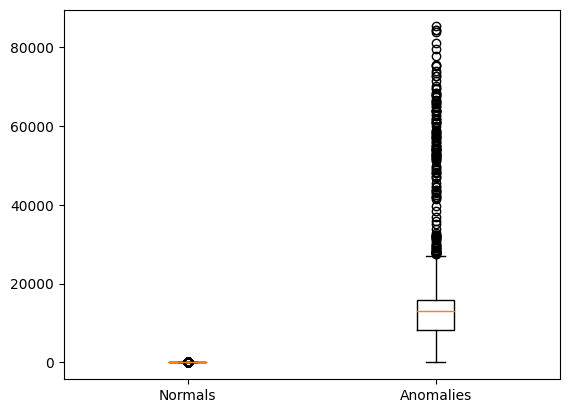

In [47]:
B = plt.boxplot([normal,anomalies])
plt.xticks([1, 2], ['Normals', 'Anomalies'])

([<matplotlib.axis.XTick at 0x141c599c0>], [Text(1, 0, 'Normals')])

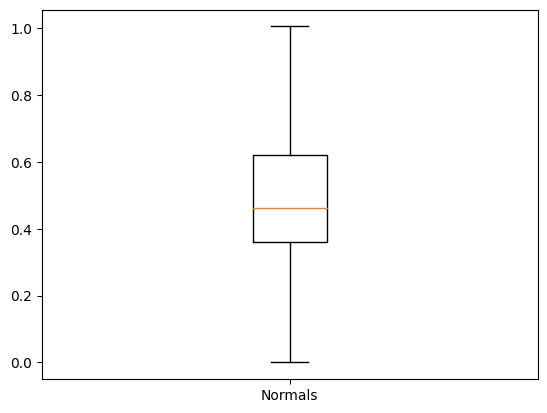

In [48]:
B = plt.boxplot(normal,showfliers=False)
plt.xticks([1], ['Normals'])

In [49]:
model['QuantileFilter'].quantile.get()

0.9475284820286539

In [50]:
#### FIXED TRESHOLD

if quantile_filter == 0:

    count=0
    progressive_count=0
    labels=0
    anomalies_window = 0
    metric2_list = []
    threshold = 2

    for idx, x in tqdm(enumerate(dataset_test)):

        y = test_labels[idx,0]

        score = model.score_one(x=x)
        print(score)

        is_anomaly = score > threshold

        anomalies_window += is_anomaly

        #treshold = 0.8
        #if heights >= 50:

        if score < threshold:  
            model = model.learn_one(x=x)
           # heights += 1

        metric = metric.update(y, score)
        metric2 = metric2.update(y, score)

        metric_list.append(metric.get())
        metric2_list.append(metric2.get())

        report = report.update(y, is_anomaly)

        labels += y

        if idx%window == window-1:

            print(idx)

            if anomalies_window >= 5:
                print("ANOMALY DETECTED")
                count+=1
                progressive_count+=1
                print(f"PROGRESSIVE COUNT: {progressive_count}")
                if progressive_count >=3:
                    print("ABNORMAL BEHAVIOR")
            else:
                progressive_count=0

            label_window = labels/window

            report2 = report2.update(label_window, anomalies_window >= 5)

            print(f"real: {label_window}")
            print(f"detected: {anomalies_window}")
            print(f"treshold: {threshold}")
            rmse = 0
            labels = 0

            anomalies_window = 0

    print(metric)

In [51]:
#### QUANTILE TRESHOLD

if quantile_filter == 1:

    count=0
    progressive_count=0
    labels=0
    anomalies_window = 0
    metric2_list = [] 

    for idx, x in tqdm(enumerate(dataset_test)):

        y = test_labels[idx,0]

        score = model.score_one(x=x)
        print(score)

        is_anomaly = model['QuantileFilter'].classify(score)

        anomalies_window += is_anomaly

        #treshold = 0.8
        #if heights >= 50:
        treshold = model['QuantileFilter'].quantile.get()

        if score < treshold:  
            model = model.learn_one(x=x)
           # heights += 1

        metric = metric.update(y, score)
        metric2 = metric2.update(y, score)

        metric_list.append(metric.get())
        metric2_list.append(metric2.get())

        report = report.update(y, is_anomaly)

        labels += y

        if idx%window == window-1:

            print(idx)

            if anomalies_window >= 5:
                print("ANOMALY DETECTED")
                count+=1
                progressive_count+=1
                print(f"PROGRESSIVE COUNT: {progressive_count}")
                if progressive_count >=3:
                    print("ABNORMAL BEHAVIOR")
            else:
                progressive_count=0

            label_window = labels/window

            report2 = report2.update(label_window, anomalies_window >= 5)

            print(f"real: {label_window}")
            print(f"detected: {anomalies_window}")
            print(f"treshold: {treshold}")
            rmse = 0
            labels = 0

            anomalies_window = 0

    print(metric)

19it [00:00, 189.17it/s]

14759.9912109375
16253.3798828125
16772.095703125
15627.2177734375
16416.056640625
15463.55859375
16972.53515625
17755.70703125
7
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9475284820286539
15224.697265625
15117.568359375
16380.103515625
15272.7763671875
18147.8671875
16720.158203125
15840.58984375
13802.5234375
15
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9475284820286539
0.791994571685791
0.721041738986969
0.7183868885040283
0.713081419467926
0.7108503580093384
0.6905685663223267
0.6784111261367798
0.6864978075027466
23
real: 0.0
detected: 0
treshold: 0.9475284820286539
0.588213324546814
0.5158007144927979
0.36018794775009155
0.30467650294303894


38it [00:00, 95.12it/s] 

0.29529881477355957
0.3127215504646301
0.3128913342952728
0.366994172334671
31
real: 0.0
detected: 0
treshold: 0.9475284820286539
0.3491468131542206
0.3457513451576233
0.27288663387298584
0.2597157657146454
0.2839421033859253
0.3370569944381714
0.556287944316864
0.6639660000801086
39
real: 0.0
detected: 0
treshold: 0.9475284820286539
0.6713128685951233
0.5971469283103943


50it [00:00, 83.63it/s]

0.6028802990913391
0.5982740521430969
0.612873375415802
0.6101365685462952
0.6200296878814697
0.6833728551864624
47
real: 0.0
detected: 0
treshold: 0.9475284820286539
0.5647581815719604
0.45615655183792114
0.48216712474823
0.5131727457046509
0.5023515224456787
0.5232688188552856


60it [00:00, 65.88it/s]

0.5185114145278931
0.5078784823417664
55
real: 0.0
detected: 0
treshold: 0.9475284820286539
0.5176382064819336
0.45874297618865967
0.35632267594337463
0.34523600339889526
0.31144979596138
0.28792744874954224
0.28774556517601013
0.5503528118133545
63
real: 0.0
detected: 0
treshold: 0.9471658182095903
18712.82421875
19972.08203125


83it [00:01, 79.64it/s]

21838.431640625
18737.83203125
22296.609375
22632.935546875
16866.73828125
18470.099609375
71
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9471658182095903
16842.10546875
16998.369140625
17971.6875
20020.908203125
18720.849609375
15492.2412109375
16747.57421875
16197.3154296875
79
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9471658182095903
0.5380846261978149
0.5368147492408752
0.5005995631217957
0.48112159967422485
0.5540197491645813
0.6940397620201111
0.7064618468284607
0.7037258744239807


118it [00:01, 123.21it/s]

87
real: 0.0
detected: 0
treshold: 0.9471658182095903
0.7339321374893188
0.5415092706680298
0.5688843727111816
0.656984269618988
0.6835755705833435
0.6781538128852844
0.7092326879501343
0.556627631187439
95
real: 0.0
detected: 0
treshold: 0.9471658182095903
18080.029296875
14690.4658203125
18306.65625
19035.994140625
15133.29296875
18089.318359375
20479.1953125
21999.9140625
103
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9471658182095903
19135.8359375
21233.4375
22941.10546875
21462.998046875
23091.3046875
21130.79296875
20668.693359375
21633.7421875
111
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9471658182095903
15582.9453125
14438.708984375
13153.8212890625
14457.798828125
17481.892578125
17099.63671875
15268.361328125
14628.1650390625
119
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9471658182095903
13259.6708984375
14182.9970703125
16916.89453125
17548.052734375
15091.287109375
14

150it [00:01, 121.54it/s]

0.5502145886421204
0.5388151407241821
0.5615501999855042
0.46237313747406006
0.5110469460487366
0.505815327167511
135
real: 0.0
detected: 0
treshold: 0.9468032469423446
14947.7353515625
15936.28125
16197.107421875
14675.9033203125
16225.322265625
15394.896484375
14260.2158203125
15878.71875
143
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9468032469423446
0.7895178198814392
1.0372984409332275
0.8232492804527283
0.8041161894798279
0.835151731967926
0.8249162435531616
0.7922673225402832


187it [00:01, 142.28it/s]

0.7702919840812683
151
real: 0.0
detected: 1
treshold: 0.9468032469423446
7863.23876953125
8722.6552734375
9593.427734375
11588.5029296875
12397.267578125
11927.28125
8968.833984375
10232.7509765625
159
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9468032469423446
15842.8271484375
14015.52734375
15983.7158203125
17393.341796875
17346.392578125
17243.5234375
15267.8095703125
15656.17578125
167
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9468032469423446
0.7901355028152466
0.7282350063323975
0.7006268501281738
0.30924689769744873
0.3029366433620453
0.32642313838005066
0.3114343285560608
0.29714539647102356
175
real: 0.0
detected: 0
treshold: 0.9468032469423446
18328.408203125
14124.51171875
14671.95703125
18096.193359375
16661.03515625
18938.41796875
18342.8515625
13972.6865234375
183
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9468032469423446
0.3112052083015442
0.3629285395145416
0.3424091041088104
0.335

202it [00:01, 111.51it/s]

0.42428940534591675
0.44077709317207336
0.4470677673816681
0.47882458567619324
191
real: 0.0
detected: 0
treshold: 0.9465598653320046
0.48006942868232727
0.5020071864128113
0.5004329085350037
0.42629510164260864
0.7153946757316589
0.7029658555984497
0.6355851292610168
0.6257191896438599
199
real: 0.0
detected: 0
treshold: 0.9465598653320046
7511.02197265625
8194.619140625
9074.7080078125
7991.703125
8007.26953125
9364.8671875


242it [00:02, 146.24it/s]

10079.166015625
10070.46875
207
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9465598653320046
17553.5546875
18493.587890625
17601.8203125
20840.30078125
17846.470703125
13922.0126953125
16208.8115234375
20441.021484375
215
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9465598653320046
6410.62890625
5845.55078125
7036.32763671875
7728.416015625
7861.46044921875
9052.990234375
7465.0498046875
6710.70361328125
223
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9465598653320046
9142.5771484375
6938.611328125
5817.4375
7196.33544921875
6645.0693359375
9685.1416015625
10800.4228515625
9308.5458984375
231
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9465598653320046
18003.154296875
20066.806640625
14531.9951171875
16297.1337890625
18333.98046875
18878.609375
16217.55078125
15105.9140625
239
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.

259it [00:02, 120.05it/s]

0.8130857944488525
0.8367424011230469
0.9706224203109741
0.8351470232009888
0.5689291954040527
247
real: 0.0
detected: 1
treshold: 0.9465598653320046
0.5453321933746338
0.5247788429260254
0.5356847643852234
0.4496457278728485
0.4237903952598572
0.3550533354282379
0.2942696809768677
0.24890856444835663
255
real: 0.0
detected: 0
treshold: 0.9465598653320046
4976.83251953125
4908.64306640625
6856.2763671875
10136.1923828125
7823.51708984375
9343.3251953125
10942.6787109375


273it [00:02, 89.33it/s] 

8104.5107421875
263
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9465598653320046
13774.66796875
12758.244140625
16322.30859375
13331.087890625
13363.2666015625
15616.53125
15059.46484375
16185.625
271
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9465598653320046
0.267374187707901
0.29025137424468994
0.323795884847641
0.34516510367393494
0.4588225483894348
0.4529280960559845


295it [00:02, 82.15it/s]

0.4691535234451294
0.45678701996803284
279
real: 0.0
detected: 0
treshold: 0.9463165401675651
0.4668993353843689
0.4498862326145172
0.42791691422462463
0.5757487416267395
0.5677694082260132
0.5382910370826721
0.44616377353668213
0.4552690386772156
287
real: 0.0
detected: 0
treshold: 0.9463165401675651
0.45747530460357666
0.4569515287876129
0.4673011898994446
0.4623776376247406
0.4735804796218872
0.28296828269958496
0.2967722415924072
0.31263187527656555


321it [00:03, 99.66it/s]

295
real: 0.0
detected: 0
treshold: 0.9463165401675651
0.30415481328964233
0.3395044803619385
0.3412517309188843
0.30676501989364624
0.33992519974708557
0.37637174129486084
0.4002210199832916
0.3895115554332733
303
real: 0.0
detected: 0
treshold: 0.9461918256817332
0.36321043968200684
0.38113024830818176
0.6959989666938782
1.0189322233200073
0.6575415730476379
0.6526099443435669
0.709535539150238
0.6620156168937683
311
real: 0.0
detected: 1
treshold: 0.9461918256817332
23351.501953125
21697.1015625
20745.30078125
18189.76953125
18579.025390625
18720.783203125
19590.1796875
20087.349609375
319
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9461918256817332
0.6537306308746338
0.6193775534629822


349it [00:03, 116.46it/s]

0.6229016184806824
0.6730930209159851
0.6627856492996216
0.35479649901390076
0.38878947496414185
0.39917102456092834
327
real: 0.0
detected: 0
treshold: 0.9461918256817332
10661.4599609375
11768.2001953125
9887.4296875
8033.40380859375
9281.0830078125
9245.130859375
12664.8203125
10014.4765625
335
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9461918256817332
0.4963800013065338
0.6148877143859863
0.7223089337348938
1.0058867931365967
1.1021661758422852
1.0499327182769775
0.764141857624054
0.9438245892524719
343
real: 0.0
detected: 3
treshold: 0.9460671297956081
1.1286518573760986
1.1946673393249512
0.9531522393226624
0.8829879760742188
0.8495039939880371
0.8797873854637146


362it [00:03, 110.70it/s]

0.8485293388366699
0.8818747997283936
351
real: 0.0
detected: 3
treshold: 0.9460671297956081
0.721809983253479
0.6559118032455444
0.5390172600746155
0.5348678827285767
0.3906204104423523
0.5480608940124512
0.572312593460083
0.531541109085083
359
real: 0.0
detected: 0
treshold: 0.9460671297956081
18977.52734375
17210.109375
16869.810546875
15200.2890625
14930.4921875
14722.8447265625
13893.701171875
11957.73046875
367
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460671297956081
0.5378465056419373
0.5120659470558167
0.5321139097213745
0.4845522344112396
0.47650137543678284
0.41680631041526794
0.3853912353515625


390it [00:03, 122.26it/s]

0.2442530393600464
375
real: 0.0
detected: 0
treshold: 0.9460671297956081
0.26951494812965393
0.33131667971611023
0.3831408619880676
0.3794514834880829
0.3677760064601898
0.3728831112384796
0.40605273842811584
0.4334096908569336
383
real: 0.0
detected: 0
treshold: 0.9460604769303698
14581.4921875
17158.3359375
19702.87890625
19782.28125
17856.890625
13202.8583984375
18005.341796875
18604.931640625
391
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460604769303698
16717.1796875
15088.513671875
15589.98046875
16738.85546875
17269.80859375
18357.77734375
19556.509765625
20534.916015625
399
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9460604769303698
16367.40234375
18618.30078125
18376.078125
14635.2470703125
17009.599609375
21798.181640625
22226.685546875
18487.619140625
407
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9460604769303698
19753.671875
18935.01953125
22317.76953125
20838.6640625

434it [00:03, 132.06it/s]

0.4310287833213806
0.4764290750026703
0.4558787941932678
0.40285781025886536
0.34745824337005615
0.3349464535713196
0.34870007634162903
0.3490617275238037
423
real: 0.0
detected: 0
treshold: 0.9460604769303698
0.31227198243141174
0.2606836259365082
0.32317978143692017
0.2828890383243561
0.2988939881324768
0.4903046488761902
0.4837254285812378
0.4792967736721039
431
real: 0.0
detected: 0
treshold: 0.9460604769303698
0.4871327877044678
0.5884460210800171


449it [00:04, 120.92it/s]

0.5936639904975891
0.5918554663658142
0.5606812238693237
0.7317171692848206
0.7080761194229126
0.5500276684761047
439
real: 0.0
detected: 0
treshold: 0.9460538057678276
8971.4716796875
12133.6884765625
12733.07421875
11006.8828125
9756.1103515625
6950.9619140625
7587.40869140625
11058.8271484375
447
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460538057678276
13649.0927734375
13274.5302734375
12834.7958984375
14065.6376953125
16334.3115234375
17491.8828125
14755.009765625
15488.5263671875
455
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9460538057678276
20093.548828125
19031.623046875
19485.302734375
19699.994140625
20224.8671875
21659.189453125
18633.763671875
20386.046875
463
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9460538057678276
10195.2001953125
9854.150390625
9095.990234375
8857.08984375
8943.9541015625
8218.13671875
9424.5048828125
8839.0986328125
471
ANOMALY DETECTED
PROGRES

473it [00:04, 147.99it/s]

0.6619194746017456
0.6898386478424072
0.585054337978363
0.5902618765830994
0.6170271635055542
0.58198082447052
0.3981855809688568
479
real: 0.0
detected: 0
treshold: 0.9460538057678276
18422.08203125
15774.7685546875
16164.326171875
17463.01953125
20939.115234375
21165.94921875
15569.978515625
13426.798828125
487
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460538057678276
0.3911847770214081
0.38705071806907654


504it [00:04, 94.98it/s] 

0.3098694086074829
0.2829440236091614
0.26757633686065674
0.25761881470680237
0.25284841656684875
0.21737466752529144
495
real: 0.0
detected: 0
treshold: 0.9460538057678276
0.2956986427307129
0.3023024797439575
0.32524195313453674
0.3272646963596344
0.31019166111946106
0.3387410044670105
0.318550705909729
0.34856343269348145
503
real: 0.0
detected: 0
treshold: 0.9460471331348981
16633.505859375


529it [00:04, 100.02it/s]

14824.4287109375
13444.021484375
16341.4970703125
14737.7861328125
13375.8671875
15106.9990234375
17832.880859375
511
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460471331348981
0.331592857837677
0.45834681391716003
0.45268234610557556
0.5056626796722412
0.520650327205658
0.5435481071472168
0.5416064262390137
0.5286924242973328
519
real: 0.0
detected: 0
treshold: 0.9460471331348981
0.5578542351722717
0.5307236313819885
0.5772925615310669
0.5215557217597961
0.4468954801559448
0.4090147018432617
0.4038606286048889
0.37882745265960693
527
real: 0.0
detected: 0
treshold: 0.9460471331348981
0.4152141213417053
0.3857555687427521


541it [00:05, 86.60it/s] 

0.3609113395214081
0.3751194477081299
0.42363929748535156
0.39642372727394104
0.3833696246147156
0.36495867371559143
535
real: 0.0
detected: 0
treshold: 0.946040442374047
0.3349895477294922
0.3217679262161255
0.29272520542144775
0.3656673729419708
0.4237939417362213
0.4024300277233124
0.3650767207145691
0.3747836649417877
543
real: 0.0
detected: 0
treshold: 0.946040442374047
0.4128808081150055
0.43210911750793457


561it [00:05, 87.48it/s]

0.4440058767795563
0.4913502633571625
0.4874002933502197
0.41766202449798584
0.34190377593040466
0.3478436768054962
551
real: 0.0
detected: 0
treshold: 0.946040442374047
0.39289093017578125
0.358305424451828
0.3489002287387848
0.34312835335731506
0.38473984599113464
0.34537339210510254
0.39970993995666504
0.4016264081001282
559
real: 0.0
detected: 0
treshold: 0.9460337444308121
0.4093037545681
0.44322872161865234
0.370431512594223
0.36880573630332947


580it [00:05, 85.60it/s]

0.3567486107349396
0.3436814844608307
0.3179965913295746
0.29585766792297363
567
real: 0.0
detected: 0
treshold: 0.9460337444308121
0.24098321795463562
0.26216498017311096
0.25829142332077026
0.2645989954471588
0.28399428725242615
0.2820904850959778
0.31069815158843994
0.321094810962677
575
real: 0.0
detected: 0
treshold: 0.9460337444308121
0.3145052492618561
0.4916970729827881
0.6361671686172485
0.6389327049255371
0.6799585819244385


613it [00:05, 121.90it/s]

0.6816248893737793
0.663730800151825
0.6758195757865906
583
real: 0.0
detected: 0
treshold: 0.9460337444308121
18302.873046875
21090.28515625
21469.591796875
16850.716796875
13445.7109375
14684.552734375
17443.953125
20239.599609375
591
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460270270704142
19107.5859375
20507.90625
16687.189453125
12448.10546875
12175.1513671875
12550.74609375
15902.361328125
19505.01171875
599
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9460270270704142
15353.951171875
17014.0
17236.75390625
15995.388671875
16292.0400390625
17081.318359375
17839.578125
17835.412109375
607
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9460270270704142
16936.337890625
19181.470703125
19476.943359375
17948.861328125
18383.58203125
21277.580078125
19600.5078125
19071.408203125
615
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.94602702707041

626it [00:05, 116.70it/s]

0.8305097222328186
0.8016486167907715
0.6718156337738037
0.6537092328071594
0.6285022497177124
623
real: 0.0
detected: 1
treshold: 0.9460270270704142
0.5879642963409424
0.5730941891670227
0.5545444488525391
0.38746264576911926
0.372062087059021
0.3602812588214874
0.28215140104293823
0.2987816333770752
631
real: 0.0
detected: 0
treshold: 0.9460270270704142
0.38843804597854614


639it [00:06, 97.61it/s] 

0.3986022174358368
0.40100419521331787
0.45086026191711426
0.45473891496658325
0.4918232858181
0.45684295892715454
0.4483895003795624
639
real: 0.0
detected: 0
treshold: 0.9460270270704142
21911.45703125
24339.7421875
20833.4609375
19651.287109375
22495.27734375
22740.052734375
17649.232421875
17632.720703125
647
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460270270704142
15764.025390625
17860.75
20644.658203125
20633.7265625
20766.978515625
18626.5625
17264.2890625
19357.994140625
655
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9460270270704142
0.3826885223388672
0.35620051622390747


670it [00:06, 98.19it/s]

0.3489725887775421
0.36134961247444153
0.3749620318412781
0.3225365877151489
0.3370894193649292
0.3056527078151703
663
real: 0.0
detected: 0
treshold: 0.9460203096895032
9758.71484375
9950.8251953125
6476.00634765625
6870.04833984375
7543.95361328125
7246.3369140625
6960.8173828125
4832.81689453125
671
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460203096895032
18247.560546875
17690.779296875
18287.23828125


691it [00:06, 95.02it/s]

14924.0341796875
12845.583984375
18184.880859375
19776.92578125
15275.728515625
679
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9460203096895032
17124.59375
18454.2265625
18926.263671875
20572.912109375
19877.6015625
21152.23046875
22260.77734375
22358.275390625
687
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9460203096895032
0.30185040831565857
0.31254708766937256
0.4099619686603546
0.46895623207092285
0.3915453255176544
0.3475360870361328


710it [00:06, 86.30it/s]

0.39591526985168457
0.392130047082901
695
real: 0.0
detected: 0
treshold: 0.9460203096895032
16730.552734375
19105.8515625
17800.865234375
15921.787109375
13928.8671875
11523.337890625
14244.2470703125
15875.08984375
703
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460203096895032
0.5716691017150879
0.6949751377105713
0.7450814247131348
0.8306360840797424
0.8161495923995972
0.9642105102539062
0.9165406823158264
0.9335351586341858


736it [00:07, 106.52it/s]

711
real: 0.0
detected: 1
treshold: 0.9460203096895032
1.0070865154266357
1.0625927448272705
1.0188771486282349
0.946422815322876
0.9451455473899841
0.8792493343353271
0.8721827864646912
0.6668838262557983
719
real: 0.0
detected: 4
treshold: 0.9460203096895032
0.7005813717842102
0.647287905216217
0.5628793239593506
0.5275276303291321
0.41788697242736816
0.4053567945957184
0.40248268842697144
0.45836761593818665
727
real: 0.0
detected: 0
treshold: 0.9460135766040304
16610.935546875
14013.041015625
15666.291015625
16031.4541015625
18926.86328125
18532.369140625
14867.6865234375
18109.4765625
735
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460135766040304
18199.064453125
13803.6396484375
14379.0576171875
17025.44921875
14572.048828125
16939.62109375
20109.9765625
15616.673828125
743
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9460135766040304
0.5219771862030029


763it [00:07, 110.10it/s]

0.5193567872047424
0.40317851305007935
0.43801888823509216
0.4911910593509674
0.5145524144172668
0.5837307572364807
0.6988579034805298
751
real: 0.0
detected: 0
treshold: 0.9460135766040304
0.73201584815979
0.6779122352600098
0.6082354784011841
0.6167879700660706
0.6554304361343384
0.6293460726737976
0.5576593279838562
0.5072531700134277
759
real: 0.0
detected: 0
treshold: 0.9460135766040304
0.48594722151756287
0.3727656602859497
0.3456164598464966
0.35974952578544617
0.37239131331443787
0.36566364765167236
0.2904264032840729
0.3102007210254669
767
real: 0.0
detected: 0
treshold: 0.9460068491258267
0.3340178430080414
0.32790887355804443
0.24000701308250427


775it [00:07, 68.42it/s] 

0.3733178973197937
0.4125736951828003
0.4006923735141754
0.405748188495636
0.39994892477989197
775
real: 0.0
detected: 0
treshold: 0.9460068491258267
0.4106385409832001
0.4098494350910187
0.3941924273967743
0.4361479878425598


784it [00:08, 43.93it/s]

0.4797466993331909
0.34708908200263977
0.31806689500808716
0.3270932137966156
783
real: 0.0
detected: 0
treshold: 0.9460068491258267
16419.80078125
18056.5546875
13674.7490234375
13148.9677734375
12413.7412109375
13692.0654296875
14873.416015625
14393.69921875
791
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9460068491258267
8632.3203125
7990.46630859375
7476.59130859375
7674.3408203125
9281.888671875
9077.8359375


818it [00:08, 78.97it/s]

8089.048828125
8710.0517578125
799
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9460068491258267
16731.4609375
19504.58203125
21839.767578125
22563.58203125
20256.59375
18003.2734375
16021.1474609375
15941.9560546875
807
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9460068491258267
20492.912109375
17777.849609375
16063.2470703125
15441.0029296875
18519.3515625
18389.431640625
13228.92578125
14516.98828125
815
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9460068491258267
17031.060546875
16982.953125
18604.935546875
19125.73046875
17242.939453125
15810.806640625
18853.759765625
19520.041015625
823
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9460068491258267
22423.564453125
19327.44921875
18309.861328125
18198.73046875
18783.0703125


843it [00:08, 83.27it/s]

16836.373046875
15180.443359375
18045.9765625
831
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9460068491258267
0.32370349764823914
0.3563879132270813
0.3420677185058594
0.3420553505420685
0.335974782705307
0.27963101863861084
0.250889390707016
0.27270224690437317
839
real: 0.0
detected: 0
treshold: 0.9460000969980864
0.26254725456237793
0.2837951183319092
0.29211243987083435


854it [00:08, 76.30it/s]

0.2718181908130646
0.28969115018844604
0.31003710627555847
0.3292924165725708
0.3561493158340454
847
real: 0.0
detected: 0
treshold: 0.9460000969980864
0.32805243134498596
0.30640384554862976
0.3351133465766907
0.2879384160041809
0.2793915867805481
0.2743746340274811
0.23936495184898376
0.1955951452255249
855
real: 0.0
detected: 0
treshold: 0.9460000969980864
0.19904471933841705
0.20355644822120667


877it [00:09, 81.87it/s]

0.28991979360580444
0.36978089809417725
0.34928685426712036
0.3559449315071106
0.3527340292930603
0.43946006894111633
863
real: 0.0
detected: 0
treshold: 0.9459933365077847
8532.1396484375
9104.98046875
10131.6435546875
10496.5703125
11778.537109375
10237.0126953125
10349.5244140625
11321.943359375
871
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459933365077847
0.44406330585479736
0.45006483793258667
0.4367431700229645
0.43826809525489807
0.38111430406570435
0.3063552677631378


887it [00:09, 76.50it/s]

0.39833924174308777
0.43275752663612366
879
real: 0.0
detected: 0
treshold: 0.9459933365077847
0.45270785689353943
0.429712176322937
0.471121221780777
0.48063981533050537
0.518974244594574
0.4748038053512573
0.4505988657474518
0.4902341365814209
887
real: 0.0
detected: 0
treshold: 0.9459933365077847
6113.7060546875
8792.728515625
9402.2958984375


896it [00:09, 78.91it/s]

7520.35986328125
6709.419921875
5625.05419921875
7207.1787109375
7317.63134765625
895
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459933365077847
0.38788995146751404
0.35342463850975037
0.334799200296402
0.27418050169944763
0.2530919015407562


913it [00:09, 58.83it/s]

0.3730267584323883
0.4177899956703186
0.434561550617218
903
real: 0.0
detected: 0
treshold: 0.9459865557032529
0.4459689259529114
0.4065750539302826
0.4657270908355713
0.5299432873725891
0.553053081035614
0.5865573287010193
0.5753357410430908
0.6703909039497375
911
real: 0.0
detected: 0
treshold: 0.9459865557032529
0.6523693203926086
0.9515746831893921
0.922222375869751
0.920508623123169
1.0113670825958252
0.923492968082428
0.9218490719795227


923it [00:09, 67.04it/s]

0.9762029051780701
919
real: 0.0
detected: 3
treshold: 0.9459865557032529
0.9029422998428345
0.8821893334388733
0.9464163780212402
1.0886415243148804
0.9686456918716431
0.8848223686218262
0.8968808650970459
0.7166445255279541


938it [00:10, 47.59it/s]

927
real: 0.0
detected: 3
treshold: 0.9459865557032529
0.6478734016418457
0.4015256464481354
0.40318286418914795
0.48538002371788025
0.43437904119491577
0.38448628783226013
0.38537588715553284
0.3662688136100769
935
real: 0.0
detected: 0
treshold: 0.9459797783470609
0.5487121343612671
0.6668565273284912
0.6570761799812317


953it [00:10, 57.27it/s]

0.6859623789787292
0.6871345043182373
0.6208083629608154
0.6684986352920532
0.869947075843811
943
real: 0.0
detected: 0
treshold: 0.9459797783470609
0.8577814698219299
0.8803215026855469
0.6700583696365356
0.5027731657028198
0.5101693868637085
0.45894718170166016
0.4505680799484253
0.5200514197349548
951
real: 0.0
detected: 0
treshold: 0.9459797783470609
0.5201810598373413
0.3276330828666687


988it [00:10, 105.21it/s]

0.3821121156215668
0.39642801880836487
0.45303428173065186
0.5020937919616699
0.49988192319869995
0.49437224864959717
959
real: 0.0
detected: 0
treshold: 0.9459729884403975
8624.3251953125
8720.6552734375
11488.005859375
11793.306640625
11076.740234375
9087.1240234375
8536.8515625
8423.9072265625
967
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459729884403975
7003.81005859375
10064.6708984375
11753.5087890625
10201.1396484375
8984.7099609375
9811.1923828125
11083.8720703125
9023.220703125
975
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9459729884403975
12574.3974609375
11011.8076171875
10876.896484375
10914.384765625
8514.662109375
8510.0546875
11129.0625
11028.162109375
983
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459729884403975
7407.6748046875
7708.4150390625
9805.7236328125
10349.474609375
11157.7666015625
11239.39453125


1021it [00:10, 132.80it/s]

9316.19921875
8354.78515625
991
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459729884403975
8083.458984375
7549.66015625
7455.501953125
10330.755859375
9010.21875
10923.53125
12311.8037109375
10214.7109375
999
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459729884403975
18974.443359375
17885.0859375
18053.353515625
21830.03515625
20545.20703125
19667.83203125
19992.28515625
17799.4609375
1007
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459729884403975
19708.52734375
21333.015625
19134.775390625
16465.4453125
14069.50390625
16650.5078125
22186.455078125
15955.0126953125
1015
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459729884403975
19453.734375
23111.7109375
18592.6328125
21268.3125
22043.6640625
22324.95703125
22989.6953125
21877.20703125
1023
ANOMALY DETECTED
PROGRESSIVE COUNT: 8
ABNORMAL BEHAVIOR
r

1057it [00:11, 154.22it/s]

0.5116188526153564
0.4239225685596466
0.38204681873321533
0.40496575832366943
0.3586755692958832
0.3081948459148407
0.35607627034187317
0.3902921974658966
1039
real: 0.0
detected: 0
treshold: 0.9459729884403975
16215.09375
18649.607421875
20015.9375
19913.87890625
20824.7265625
22150.505859375
17725.06640625
19023.3828125
1047
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459729884403975
23400.6328125
16832.900390625
15374.294921875
18731.646484375
23232.033203125
24021.6796875
21388.01953125
19587.3359375
1055
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9459729884403975
0.37848931550979614
0.39004629850387573
0.4074040949344635
0.4702509343624115


1074it [00:11, 129.73it/s]

0.46390610933303833
0.5497941374778748
0.6754012107849121
0.8215503692626953
1063
real: 0.0
detected: 0
treshold: 0.9459729884403975
16070.77734375
15678.8916015625
17492.658203125
18852.28515625
17478.73046875
15461.900390625
12271.66796875
15137.9208984375
1071
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459729884403975
0.805000901222229
0.7368911504745483
0.745124101638794
0.7667353749275208
0.7401850819587708
0.6970294713973999
0.6869351863861084
0.5904479026794434
1079
real: 0.0
detected: 0
treshold: 0.9459662012807575
0.562457799911499


1089it [00:11, 112.51it/s]

0.4785259962081909
0.39415279030799866
0.39744770526885986
0.40665459632873535
0.3857167363166809
0.3761991858482361
0.3972584009170532
1087
real: 0.0
detected: 0
treshold: 0.9459662012807575
0.4125910997390747
0.42231079936027527
0.34430649876594543
0.2818410396575928
0.3578796684741974
0.3829829692840576
0.45096373558044434


1119it [00:11, 117.44it/s]

0.4320817291736603
1095
real: 0.0
detected: 0
treshold: 0.9459662012807575
10517.1875
8217.2685546875
7864.54541015625
7773.09228515625
9389.7216796875
9467.7109375
10393.6640625
10978.1484375
1103
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459662012807575
7442.044921875
11572.65234375
9166.048828125
7017.70556640625
9148.5927734375
8569.9072265625
7891.96484375
8892.9091796875
1111
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9459662012807575
0.4305398464202881
0.39464160799980164
0.3725167214870453
0.3554931581020355
0.5154004096984863
0.5725533366203308
0.4955756366252899
0.4640052318572998
1119
real: 0.0
detected: 0
treshold: 0.9459593942057022
0.4030245840549469
0.4361972510814667
0.4780787527561188
0.554151177406311


1144it [00:12, 110.42it/s]

0.6041954755783081
0.6676649451255798
0.7139436602592468
0.6504955291748047
1127
real: 0.0
detected: 0
treshold: 0.9459593942057022
0.6776129007339478
0.9015486240386963
1.1032631397247314
0.9561682939529419
1.100425362586975
0.9115872979164124
0.9273826479911804
0.9087530374526978
1135
real: 0.0
detected: 3
treshold: 0.9459593942057022
0.8390107154846191
0.7981933355331421
0.7797095775604248
0.5618250370025635
0.5591725707054138
0.5467727780342102
0.3322882354259491
0.32340240478515625
1143
real: 0.0
detected: 0
treshold: 0.9459593942057022
0.3178475499153137
0.3510085940361023


1156it [00:12, 93.18it/s] 

0.35349041223526
0.3430565297603607
0.3078465461730957
0.3042052984237671
0.32589343190193176
0.31411415338516235
1151
real: 0.0
detected: 0
treshold: 0.9459525918837225
0.3487592339515686
0.3573637306690216
0.3592629134654999
0.34062233567237854
0.3545965254306793
0.3586835563182831
0.3602384328842163
0.36376965045928955


1176it [00:12, 83.89it/s]

1159
real: 0.0
detected: 0
treshold: 0.9459525918837225
0.3448115885257721
0.4299793243408203
0.4173427224159241
0.4196920394897461
0.41969767212867737
0.402369886636734
0.41636812686920166
0.4383096992969513
1167
real: 0.0
detected: 0
treshold: 0.9459525918837225
0.44405433535575867
0.4684945046901703
0.4667549431324005
0.3717937767505646
0.35504794120788574
0.3473149240016937
0.32721832394599915
0.3220089077949524
1175
real: 0.0
detected: 0
treshold: 0.9459457671403352


1185it [00:12, 77.93it/s]

0.28352802991867065
0.24876858294010162
0.22243686020374298
0.2012157440185547
0.2944778501987457
0.29476824402809143
0.26990601420402527
0.3275713324546814
1183
real: 0.0
detected: 0
treshold: 0.9459457671403352
0.312565416097641
0.3004359304904938
0.3266924023628235
0.3337101638317108
0.3338838219642639
0.3473878800868988
0.2538995146751404
0.2935439348220825
1191
real: 0.0
detected: 0
treshold: 0.9459457671403352
7131.31396484375


1230it [00:12, 145.67it/s]

7151.24755859375
8327.01953125
7457.28076171875
8335.96484375
8119.47607421875
9372.4912109375
8335.9091796875
1199
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459457671403352
21239.3984375
19175.583984375
19385.984375
21232.67578125
19246.2578125
17546.68359375
15555.56640625
14167.833984375
1207
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9459457671403352
17851.5859375
18241.6640625
14373.3203125
12513.2958984375
14237.771484375
15535.8173828125
15205.263671875
15649.021484375
1215
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459457671403352
12663.9951171875
15771.853515625
20004.458984375
16001.580078125
13967.5625
15770.7314453125
17258.34375
20656.533203125
1223
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459457671403352
22312.470703125
22230.21484375
23047.0859375
23098.150390625
21414.259765625
17494.521484375
17197.482421875
17341

1246it [00:12, 131.09it/s]

1239
real: 0.0
detected: 0
treshold: 0.9459389343534347
0.5046629309654236
0.5454499125480652
0.5816286206245422
0.5277506113052368
0.5142881274223328
0.5237083435058594
0.48709431290626526
0.4775543212890625
1247
real: 0.0
detected: 0
treshold: 0.9459389343534347
0.5460163354873657
0.5627914667129517
0.5423937439918518
0.4460648000240326
1.0381479263305664
0.594078004360199
0.5272808074951172
0.5436558723449707
1255
real: 0.0
detected: 1
treshold: 0.9459389343534347
0.5303006768226624
0.5440163612365723
0.5627824664115906
0.5257765054702759
0.5859281420707703


1277it [00:13, 128.57it/s]

0.5478998422622681
0.5527446269989014
0.3426157236099243
1263
real: 0.0
detected: 0
treshold: 0.9459320920300174
8923.4912109375
7816.134765625
6177.33740234375
6974.494140625
10967.96484375
8471.6767578125
7698.0986328125
8455.0703125
1271
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459320920300174
1.3448704481124878
0.7156170606613159
0.8036977648735046
0.8224925398826599
0.8633880019187927
0.9786876440048218
1.2079967260360718
0.9892757534980774
1279
real: 0.0
detected: 4
treshold: 0.9459320920300174
0.8619275093078613
0.8516262173652649
0.8715245127677917
1.1768879890441895
0.9430899620056152
0.9456868171691895
0.9387723803520203
0.5754489302635193
1287
real: 0.0
detected: 1
treshold: 0.9459320920300174
0.4679050147533417
0.44616347551345825


1291it [00:13, 121.27it/s]

0.41391196846961975
0.398395299911499
0.3577045798301697
0.25235432386398315
0.22122564911842346
0.41200530529022217
1295
real: 0.0
detected: 0
treshold: 0.9459320920300174
0.4695007801055908
0.4854954779148102
0.7716401815414429
0.8586301207542419
0.8666035532951355
0.8714275360107422


1315it [00:13, 86.43it/s] 

0.9113994836807251
0.8953680396080017
1303
real: 0.0
detected: 0
treshold: 0.9459252530504567
0.8682733178138733
0.7621689438819885
0.7386596202850342
0.7220313549041748
0.41815415024757385
0.619574785232544
0.6218916773796082
0.6566660404205322
1311
real: 0.0
detected: 0
treshold: 0.9459252530504567
7580.9501953125
7506.01171875
8540.9501953125
9687.328125


1335it [00:13, 89.25it/s]

9937.8037109375
8763.1943359375
8396.640625
8904.302734375
1319
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459252530504567
0.6430394053459167
0.7322635650634766
0.6988629102706909
0.7838124632835388
0.8253836631774902
0.8068302869796753
0.8019921183586121
0.5517116785049438
1327
real: 0.0
detected: 0
treshold: 0.9459252530504567
0.6287674307823181
0.645922064781189
0.6454501152038574
0.6110588312149048
0.7121546268463135
0.5326284766197205
0.46316149830818176
0.4757447838783264
1335
real: 0.0
detected: 0
treshold: 0.9459184066428918
20864.5078125
19717.05078125


1374it [00:14, 133.56it/s]

19410.123046875
18974.046875
15961.943359375
20134.20703125
20344.494140625
19545.783203125
1343
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459184066428918
17482.83203125
17241.197265625
16844.26171875
17302.5078125
17313.869140625
17846.4921875
20452.70703125
20137.056640625
1351
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9459184066428918
19849.4140625
19814.869140625
22924.322265625
26144.828125
21395.94921875
24788.2421875
18945.015625
16864.76171875
1359
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459184066428918
7999.67822265625
9427.5712890625
9198.96484375
8285.125
9067.7158203125
8685.365234375
8793.76171875
9831.3212890625
1367
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459184066428918
8022.833984375
8730.1357421875
11202.677734375
11176.99609375
10520.2236328125
9992.8115234375
10670.33984375
7550.1943359375
1375
ANOMALY DET

1399it [00:14, 164.45it/s]

7901.89013671875
8302.76171875
5447.70263671875
6645.291015625
9469.767578125
10575.150390625
1383
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459184066428918
16003.318359375
18810.650390625
19093.03515625
20838.474609375
19107.7734375
18495.4921875
21308.5234375
23780.9921875
1391
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459184066428918
21110.494140625
21158.634765625
25198.98828125
24684.982421875
20083.28515625
18706.5234375
20168.30859375
20415.73828125
1399
ANOMALY DETECTED
PROGRESSIVE COUNT: 8
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9459184066428918
0.49613747000694275
0.5972443222999573
0.517669677734375
0.49366751313209534
0.469086617231369
0.5717993378639221
0.6721423864364624
0.7010788917541504
1407
real: 0.0
detected: 0
treshold: 0.9459184066428918
0.7238516211509705
0.732096254825592
0.7350320219993591
0.7555936574935913
1.299147605895996
2.0445613861083984


1433it [00:14, 141.62it/s]

0.9447312355041504
0.9445328712463379
1415
real: 0.0
detected: 2
treshold: 0.9459184066428918
0.9526448249816895
0.9908949136734009
0.9738103747367859
0.9434422254562378
0.8197472095489502
0.6257914900779724
0.6701341271400452
0.6442877054214478
1423
real: 0.0
detected: 3
treshold: 0.9459184066428918
17275.041015625
17602.751953125
16601.0546875
14692.25
13919.6728515625
17214.408203125
17121.55078125
15470.9521484375
1431
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459184066428918
0.7387368679046631
0.718123197555542
0.6243411898612976
0.5014268755912781
0.5409744381904602
0.5678218007087708


1449it [00:14, 116.77it/s]

0.5946375131607056
0.6482236981391907
1439
real: 0.0
detected: 0
treshold: 0.9459115688244171
0.5986772775650024
0.6676110029220581
0.600249171257019
0.6201320886611938
0.5687374472618103
0.5615667104721069
0.6439299583435059
0.6227157115936279
1447
real: 0.0
detected: 0
treshold: 0.9459115688244171
17229.001953125
15022.63671875
13815.775390625
15911.59375
18159.771484375
18898.22265625
17451.154296875
16310.1689453125
1455
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9459115688244171
0.5826138854026794
0.5306240320205688


1475it [00:14, 113.04it/s]

0.6851844787597656
3.280143976211548
0.919150173664093
0.9360857605934143
0.9150469303131104
0.9276406168937683
1463
real: 0.0
detected: 1
treshold: 0.9459115688244171
0.9904220700263977
0.8829899430274963
0.7779674530029297
0.763129472732544
0.7302509546279907
0.7437822818756104
0.596836268901825
0.294496089220047
1471
real: 0.0
detected: 1
treshold: 0.9459047243779364
0.24625232815742493
0.23818764090538025
0.23555047810077667
0.21723799407482147
0.18403829634189606


1487it [00:15, 92.67it/s] 

0.23549436032772064
0.27561068534851074
0.26419946551322937
1479
real: 0.0
detected: 0
treshold: 0.9459047243779364
0.25097596645355225
0.2668161690235138
0.2906581163406372
0.28934580087661743
0.3000841438770294
0.3258437216281891
0.3366771340370178
0.3085802495479584
1487
real: 0.0
detected: 0
treshold: 0.9459047243779364
0.2893134355545044
0.28908005356788635
0.27216804027557373
0.2732025980949402
0.25877150893211365
0.25486263632774353
0.24638943374156952


1508it [00:15, 92.16it/s]

0.2198222130537033
1495
real: 0.0
detected: 0
treshold: 0.9458978721097832
0.247502401471138
0.2549554705619812
0.2401031255722046
0.24520602822303772
0.2651475965976715
0.3137819766998291
0.32532310485839844
0.32114750146865845
1503
real: 0.0
detected: 0
treshold: 0.9458978721097832
0.3605177700519562
0.35474762320518494
0.3630180060863495
0.3406740427017212
0.3498777449131012
0.38592177629470825
0.38023126125335693
0.3475830554962158
1511
real: 0.0
detected: 0
treshold: 0.9458978721097832
0.3622610867023468
0.3838411569595337


1518it [00:15, 87.44it/s]

0.3747325837612152
0.4298185706138611
0.46701154112815857
0.5132575035095215
0.5150132179260254
0.500923752784729
1519
real: 0.0
detected: 0
treshold: 0.9458978721097832
0.5573425889015198
0.539408266544342
0.5276448726654053
0.5383102893829346
0.520625114440918
0.534517228603363


1543it [00:15, 88.22it/s]

0.4745849668979645
0.4595509469509125
1527
real: 0.0
detected: 0
treshold: 0.945891000250585
7746.3193359375
8201.5595703125
9622.6787109375
9469.52734375
11867.9501953125
10404.5517578125
9238.7509765625
11292.4033203125
1535
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945891000250585
9927.8642578125
9028.6376953125
9163.3720703125
9609.1748046875
11495.7900390625
9788.849609375
10455.6416015625
10911.4951171875
1543
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945891000250585
22605.814453125
22017.6484375
17916.533203125
21328.970703125
20434.642578125
16009.912109375
19078.775390625
19445.466796875
1551
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945891000250585
19371.32421875
22550.3359375
19202.630859375
19531.568359375
23439.3984375


1576it [00:16, 108.68it/s]

22947.76171875
19675.55078125
18402.421875
1559
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945891000250585
0.45304879546165466
0.4342644214630127
0.3941667973995209
0.4189161956310272
0.38278672099113464
0.35975372791290283
0.3931714594364166
0.3547132611274719
1567
real: 0.0
detected: 0
treshold: 0.945891000250585
0.377986878156662
0.6344768404960632
0.657225489616394
0.6586925983428955
0.6456448435783386
0.6098850965499878
0.5973571538925171
0.613191545009613
1575
real: 0.0
detected: 0
treshold: 0.945891000250585
0.5644499063491821
0.559462308883667
0.5522781610488892


1588it [00:16, 103.54it/s]

0.2822781503200531
0.32819244265556335
0.31135785579681396
0.2935604155063629
0.3138146698474884
1583
real: 0.0
detected: 0
treshold: 0.9458841316568362
0.3199704885482788
0.28960323333740234
0.2998490631580353
0.33505240082740784
0.3054593801498413
0.2927761971950531
0.28638917207717896
0.2937543988227844
1591
real: 0.0
detected: 0
treshold: 0.9458841316568362
0.3771854043006897
0.41589680314064026
0.4424627423286438


1609it [00:16, 85.66it/s] 

0.5369486212730408
0.5240615606307983
0.5075414180755615
0.5553272366523743
0.564276397228241
1599
real: 0.0
detected: 0
treshold: 0.9458841316568362
0.5369682908058167
0.5362573862075806
0.4796665608882904
0.4221281409263611
0.3961177170276642
0.3268853425979614
0.3484749495983124
0.32689547538757324
1607
real: 0.0
detected: 0
treshold: 0.945877246224578
21156.345703125
20518.615234375
18286.05078125
20920.0234375
20779.787109375
14900.451171875
16243.3837890625


1643it [00:16, 118.90it/s]

17472.841796875
1615
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945877246224578
18087.37890625
17323.689453125
19129.384765625
19863.470703125
17599.474609375
18984.796875
20833.45703125
20357.767578125
1623
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945877246224578
21682.345703125
23209.921875
21803.0078125
20261.513671875
18569.60546875
22158.1796875
21301.703125
20914.181640625
1631
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945877246224578
0.33124279975891113
0.32533547282218933
0.3331359624862671
0.346007764339447
0.3429985046386719
0.3394140303134918
0.3695574104785919
0.5011739134788513
1639
real: 0.0
detected: 0
treshold: 0.945877246224578
19344.98046875
16558.447265625
15601.1484375
17368.248046875
16265.8671875
13385.9814453125
14863.05859375
15691.34375
1647
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945877246224578
18648.61328125
20819.658203

1675it [00:16, 126.00it/s]

16609.833984375
18046.498046875
1655
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945877246224578
0.5142174959182739
0.5355802774429321
0.5457488894462585
0.5602490901947021
0.5354542136192322
0.550597071647644
0.5426434278488159
0.5448368191719055
1663
real: 0.0
detected: 0
treshold: 0.945877246224578
0.5423471927642822
0.46683281660079956
0.451346755027771
0.44862422347068787
0.37297770380973816
0.5483253002166748
1.0930770635604858
0.8194693922996521
1671
real: 0.0
detected: 1
treshold: 0.9458703601723245
22043.29296875
20978.912109375
21879.08203125
21449.400390625
23653.974609375
23114.69921875
18436.990234375
17478.921875
1679
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9458703601723245


1693it [00:17, 138.93it/s]

20988.54296875
17647.171875
16275.5029296875
20267.4296875
18371.232421875
19157.974609375
23976.390625
22895.296875
1687
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9458703601723245
0.8126716613769531
0.8343212604522705
0.8530353307723999
0.8774416446685791
0.8469587564468384
0.8649404644966125
0.9570480585098267
0.8772596120834351
1695
real: 0.0
detected: 1
treshold: 0.9458703601723245
0.883138120174408
0.7199909090995789
0.44744622707366943
0.42386481165885925
0.385264128446579
0.3512971103191376
0.35176223516464233
0.33803486824035645
1703
real: 0.0
detected: 0
treshold: 0.9458703601723245
0.29853808879852295
0.2532392740249634


1724it [00:17, 129.65it/s]

0.23912368714809418
0.211819127202034
0.2179393321275711
0.21340467035770416
0.22067929804325104
0.23874786496162415
1711
real: 0.0
detected: 0
treshold: 0.9458634587135365
20962.662109375
20941.154296875
20740.82421875
19978.568359375
18031.04296875
18344.287109375
16164.5078125
17568.271484375
1719
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9458634587135365
0.2667582929134369
0.25327056646347046
0.2559427320957184
0.2628743350505829
0.2630396783351898
0.25777971744537354
0.2704489827156067
0.2885302007198334
1727
real: 0.0
detected: 0
treshold: 0.9458634587135365
0.29864609241485596
0.3140389919281006


1752it [00:17, 122.82it/s]

0.23111781477928162
0.24207982420921326
0.24605043232440948
0.28010058403015137
0.3328423798084259
0.34623679518699646
1735
real: 0.0
detected: 0
treshold: 0.9458634587135365
14329.861328125
15838.6572265625
18854.900390625
21015.359375
19477.86328125
19541.734375
18081.9921875
18729.29296875
1743
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9458634587135365
0.3721340298652649
0.3389877378940582
0.35735759139060974
0.32204368710517883
0.33392661809921265
0.30859705805778503
0.2932572662830353
0.26653853058815
1751
real: 0.0
detected: 0
treshold: 0.9458565496552593
9777.15625
9841.458984375
10664.8359375


1786it [00:17, 141.10it/s]

11879.2216796875
12328.6220703125
10302.1103515625
11423.30078125
11504.603515625
1759
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9458565496552593
19391.087890625
24442.4375
24711.564453125
23178.658203125
21622.9140625
19753.779296875
23483.607421875
20431.63671875
1767
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9458565496552593
18010.97265625
22835.927734375
21142.83203125
20063.96484375
21128.0078125
22380.642578125
17243.41796875
13849.818359375
1775
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458565496552593
21047.904296875
19425.8359375
18539.283203125
18573.4921875
19579.03515625
21607.67578125
20242.296875
15911.7978515625
1783
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458565496552593
15150.572265625
16291.5751953125


1813it [00:17, 174.69it/s]

15780.4228515625
18280.439453125
19368.568359375
16146.7822265625
14464.068359375
17689.70703125
1791
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458565496552593
18867.958984375
17704.13671875
20297.931640625
19604.630859375
17150.609375
19282.404296875
16421.681640625
15656.3349609375
1799
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458565496552593
8277.564453125
7194.236328125
8233.146484375
8689.8173828125
9659.1015625
11386.6728515625
6972.7431640625
7903.2724609375
1807
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458565496552593
22112.634765625
23285.802734375
22621.9140625
24159.419921875
23723.58203125
22701.908203125
18065.0625
17380.017578125
1815
ANOMALY DETECTED
PROGRESSIVE COUNT: 8
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458565496552593
21075.23046875
18443.681640625
19695.8203125
17336.931640625
17097.5859375
14954.565429

1850it [00:18, 146.94it/s]

1831
real: 0.0
detected: 0
treshold: 0.9458565496552593
0.37118545174598694
0.5914685726165771
0.7023305296897888
0.8035385608673096
0.7699456214904785
0.7342239618301392
0.7612131237983704
0.7741143107414246
1839
real: 0.0
detected: 0
treshold: 0.9458565496552593
0.8128100037574768
0.821810781955719
1.250656247138977
1.208184003829956
0.8267926573753357
0.593212902545929
0.5145887136459351
0.45146897435188293
1847
real: 0.0
detected: 2
treshold: 0.9458565496552593
11518.181640625
10863.8486328125
12885.2109375
11151.6591796875
12150.4541015625
16352.8125
14765.9248046875
14569.79296875
1855
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9458565496552593
13223.1279296875
11193.2890625
8067.96240234375
10221.1279296875


1867it [00:18, 151.31it/s]

11169.9697265625
9474.5849609375
9095.650390625
6729.5087890625
1863
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9458565496552593
0.7378608584403992
1.064774990081787
0.7760420441627502
0.732866644859314
0.7092744708061218
0.618166983127594
0.6077049970626831
0.7490419745445251
1871
real: 0.0
detected: 1
treshold: 0.9458496284741634
0.7886347770690918
0.7786211967468262
0.736756443977356
0.4029221832752228


1883it [00:18, 118.96it/s]

0.3644472062587738
0.4617043435573578
0.4610265791416168
0.4587515890598297
1879
real: 0.0
detected: 0
treshold: 0.9458496284741634
0.4943917989730835
0.34664615988731384
0.32481926679611206
0.319039523601532
0.30898788571357727
0.40951624512672424
0.5125361084938049
0.43465134501457214
1887
real: 0.0
detected: 0
treshold: 0.9458496284741634
0.45721203088760376
0.4747222065925598
0.43681299686431885
0.43146592378616333
0.434671550989151
0.44765812158584595
0.46170294284820557
0.3791019320487976
1895
real: 0.0
detected: 0
treshold: 0.9458427085884525


1910it [00:18, 102.47it/s]

0.32672423124313354
0.32692989706993103
0.3545183539390564
0.35638976097106934
0.35875070095062256
0.4038142263889313
0.3967747092247009
0.3852723240852356
1903
real: 0.0
detected: 0
treshold: 0.9458427085884525
0.3869422674179077
0.3761574625968933
0.32380691170692444
0.3325478732585907
0.29821881651878357
0.289143443107605
0.31634190678596497
0.26856881380081177
1911
real: 0.0
detected: 0
treshold: 0.9458427085884525
0.24629421532154083


1921it [00:18, 97.65it/s] 

0.24590694904327393
0.2392469048500061
0.24073785543441772
0.2679312527179718
0.25749969482421875
0.2863270044326782
0.32141757011413574
1919
real: 0.0
detected: 0
treshold: 0.9458357672641322
0.3680962324142456
0.378243088722229
0.37054842710494995
0.34245121479034424
0.3481098413467407
0.35643988847732544
0.3299093246459961
0.31078997254371643
1927
real: 0.0
detected: 0
treshold: 0.9458357672641322


1945it [00:19, 98.74it/s]

16415.724609375
16953.994140625
15155.5625
14951.021484375
17477.693359375
17789.681640625
16164.771484375
18530.439453125
1935
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9458357672641322
19508.689453125
20189.583984375
15267.919921875
16872.763671875
18122.400390625
16460.703125
14903.6650390625
18438.5703125
1943
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9458357672641322
0.2784704566001892
0.3797188103199005
0.6116821765899658
0.6103771924972534
0.6727769374847412
0.7049600481987
0.7276131510734558
0.7585944533348083
1951
real: 0.0
detected: 0
treshold: 0.9458357672641322


1969it [00:19, 105.44it/s]

1.466241478919983
0.8701275587081909
0.9171924591064453
1.0009233951568604
1.235041856765747
1.448464035987854
1.7126381397247314
1.0036771297454834
1959
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 0.0
detected: 6
treshold: 0.9458357672641322
1.0756828784942627
0.8891622424125671
0.7471088171005249
0.5672834515571594
0.5599775314331055
0.5265613794326782
0.509093701839447
0.5486932992935181
1967
real: 0.0
detected: 1
treshold: 0.945828826616971
0.5412048697471619
0.5818146467208862
0.5383064150810242
0.558855414390564
0.5543420314788818
0.45169389247894287
0.45142659544944763
0.4259569048881531


2001it [00:19, 128.53it/s]

1975
real: 0.0
detected: 0
treshold: 0.945828826616971
0.5731834769248962
0.4997800588607788
0.46419909596443176
0.32051873207092285
0.3082563877105713
0.28161588311195374
0.30092108249664307
0.29594776034355164
1983
real: 0.0
detected: 0
treshold: 0.945828826616971
21171.359375
20141.77734375
17049.908203125
16128.9326171875
15879.1220703125
15248.58203125
17072.0859375
17563.234375
1991
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945828826616971
21835.0859375
18590.505859375
14613.794921875
19933.904296875
25979.908203125
23390.841796875
23338.48046875
25720.5625
1999
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945828826616971
23839.470703125
21080.234375
28241.25
27374.32421875
22883.931640625
29722.38671875
27502.783203125
28329.45703125
2007
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945828826616971
10136.32421875
9952.146484375


2029it [00:19, 116.79it/s]

9746.3896484375
8824.5234375
7950.59326171875
9008.5634765625
9185.697265625
9080.05859375
2015
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945828826616971
0.3009626865386963
0.3049820065498352
0.16895383596420288
0.18743310868740082
0.22504116594791412
0.23257242143154144
0.2515430450439453
0.2609279155731201
2023
real: 0.0
detected: 0
treshold: 0.9458218715531502
9780.431640625
8678.8154296875
12419.3173828125
12867.7578125
12807.5615234375
11007.6474609375
9715.791015625


2046it [00:20, 128.16it/s]

12288.576171875
2031
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9458218715531502
20397.798828125
21193.375
18120.6015625
17802.927734375
23202.3203125
21293.384765625
17521.08203125
14385.1611328125
2039
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9458218715531502
0.2357633411884308
0.23622776567935944
0.2610098421573639
0.5680750608444214
0.5821000337600708
0.5609819293022156
0.553303599357605
0.5382824540138245
2047
real: 0.0
detected: 0
treshold: 0.9458218715531502
0.6478157639503479
0.7142971754074097
0.7530945539474487
0.750518798828125
0.7534146904945374
0.46586158871650696
0.46878838539123535
0.4877116084098816
2055
real: 0.0
detected: 0
treshold: 0.9458218715531502
0.46481114625930786


2060it [00:20, 114.95it/s]

0.4674670100212097
0.3727225065231323
0.6714929342269897
0.7479385137557983
0.7668421268463135
0.7280505895614624
0.7575399875640869
2063
real: 0.0
detected: 0
treshold: 0.9458149215040191
0.7907577753067017
0.815014660358429
0.8168987035751343
0.829434871673584
0.822683572769165
0.525656521320343
0.8399990200996399


2084it [00:20, 98.97it/s] 

1.004136562347412
2071
real: 0.0
detected: 1
treshold: 0.9458149215040191
0.8792523741722107
0.9105240702629089
0.8972380757331848
0.8532257676124573
0.8844408988952637
0.932728111743927
0.9944580793380737
1.005021333694458
2079
real: 0.0
detected: 2
treshold: 0.9458149215040191
0.9227035045623779
0.8774226307868958
0.825452446937561
0.4317035675048828
0.40070873498916626
0.37394654750823975
0.3822160065174103
0.3682801127433777
2087
real: 0.0
detected: 0
treshold: 0.9458149215040191
0.3022002875804901
0.248624786734581
0.26370030641555786
0.3060539960861206


2095it [00:20, 95.18it/s]

0.3067779541015625
0.31213319301605225
0.30144205689430237
0.37108924984931946
2095
real: 0.0
detected: 0
treshold: 0.9458079596649869
0.3551599085330963
0.3502521514892578
0.3844335973262787
0.4030740261077881
0.3753626346588135
0.3917750418186188
0.40789633989334106


2117it [00:20, 87.59it/s]

0.395315945148468
2103
real: 0.0
detected: 0
treshold: 0.9458079596649869
0.4743581712245941
0.5174742341041565
0.49868065118789673
0.5146228075027466
0.48147377371788025
0.4734523296356201
0.47324642539024353
0.4402001202106476
2111
real: 0.0
detected: 0
treshold: 0.9458079596649869
18668.1953125
17221.041015625
15459.9912109375
15432.451171875
18300.98046875
21783.509765625
18710.537109375
18718.96484375
2119
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9458079596649869
23593.77734375
22835.67578125
26979.16796875
21873.654296875
17489.134765625
18546.4453125
20739.751953125
23612.751953125
2127
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9458079596649869
24619.8359375
27551.890625
23762.63671875
29189.470703125
26208.681640625
27121.400390625
19753.1796875
17224.888671875
2135
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458079596649869


2168it [00:21, 161.83it/s]

19406.466796875
19745.6875
19470.056640625
18489.376953125
19305.505859375
20197.484375
19401.6796875
20377.9453125
2143
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458079596649869
9281.0146484375
8738.7060546875
9806.1494140625
8611.6865234375
8330.1884765625
9301.4501953125
9335.5927734375
9956.060546875
2151
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458079596649869
11144.5791015625
7571.404296875
5874.72802734375
6850.68603515625
7590.966796875
8813.962890625
9020.353515625
8299.318359375
2159
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458079596649869
11901.2041015625
13819.8310546875
10713.3759765625
9256.8388671875
10857.0849609375
12582.630859375
10965.1904296875
10659.451171875
2167
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458079596649869
25728.814453125
24297.91015625
24009.515625
23386.

2217it [00:21, 161.19it/s]

17794.5703125
18317.205078125
16925.3671875
18289.9453125
19152.126953125
19921.15234375
16021.2841796875
2199
ANOMALY DETECTED
PROGRESSIVE COUNT: 11
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9458079596649869
0.3983023464679718
0.4614897072315216
0.3758261203765869
0.29239460825920105
0.355090856552124
0.3382551670074463
0.32484859228134155
0.3317469358444214
2207
real: 0.0
detected: 0
treshold: 0.9458009954181452
0.32172301411628723
0.3274209201335907
0.46355271339416504
0.41126328706741333
0.40467318892478943
0.4444267153739929
0.4326416254043579
0.4499753713607788
2215
real: 0.0
detected: 0
treshold: 0.9458009954181452
0.4927856922149658
0.4742942154407501
0.5042182803153992
0.5501067638397217
0.433308869600296
0.4697812795639038
0.4671260118484497
0.4025212228298187
2223
real: 0.0
detected: 0
treshold: 0.9458009954181452
0.3668881356716156
0.33860984444618225
0.34694960713386536
0.361435204744339
0.3340110778808594
0.2601463198661804
0.24818095564842224
0.1917264908552169

2235it [00:21, 116.01it/s]

0.4411555230617523
0.48492431640625
0.49385014176368713
0.4619561731815338
0.5173734426498413
0.6292111873626709
0.7368428111076355
2239
real: 0.0
detected: 0
treshold: 0.9457940145906314
0.8061231970787048
0.8198091983795166
0.5763126611709595
0.8467573523521423
1.0251901149749756
0.8039681315422058
0.8540286421775818


2250it [00:21, 96.23it/s] 

0.8609780073165894
2247
real: 0.0
detected: 1
treshold: 0.9457940145906314
0.8012299537658691
0.7196000814437866
0.6302172541618347
0.5480201840400696
0.5623500347137451
0.8039158582687378
0.578574538230896
0.6916525363922119
2255
real: 0.0
detected: 0
treshold: 0.9457870393074992
0.6699405908584595
0.6486756205558777
0.7220305800437927
0.7474180459976196
0.7885870337486267
0.8013633489608765


2274it [00:22, 82.23it/s]

0.7649198174476624
0.5337395071983337
2263
real: 0.0
detected: 0
treshold: 0.9457870393074992
0.49765610694885254
0.4075848460197449
0.37986552715301514
0.3844927251338959
0.3298244774341583
0.2842086851596832
0.2631617784500122
0.2559725046157837
2271
real: 0.0
detected: 0
treshold: 0.9457870393074992
17717.2578125
17953.650390625


2322it [00:22, 143.18it/s]

18029.14453125
17250.990234375
15710.9140625
20012.103515625
20147.431640625
18902.732421875
2279
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457870393074992
8858.177734375
9176.0966796875
8670.9326171875
7922.89453125
8832.4716796875
8624.009765625
10268.4677734375
8624.3740234375
2287
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9457870393074992
19474.3125
20342.92578125
17508.353515625
15256.7685546875
17354.07421875
17753.408203125
19282.185546875
22043.533203125
2295
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457870393074992
20897.8984375
24942.109375
17335.7109375
17332.07421875
14638.880859375
15650.6552734375
18844.4921875
17788.2265625
2303
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457870393074992
10616.5771484375
8502.0810546875
10065.703125
12186.712890625
10671.53125
11131.59375
9711.3203125
8615.7529296875
2311
ANOMALY DET

2351it [00:22, 176.74it/s]

20676.818359375
2327
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457870393074992
16699.01953125
18839.3984375
18987.404296875
22849.6953125
17677.0078125
17582.7265625
16035.6826171875
13534.94921875
2335
ANOMALY DETECTED
PROGRESSIVE COUNT: 8
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457870393074992
21694.23046875
21222.90234375
19550.880859375
19381.185546875
19506.90625
18287.82421875
18825.083984375
19250.759765625
2343
ANOMALY DETECTED
PROGRESSIVE COUNT: 9
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457870393074992
20796.845703125
15840.337890625
15910.0966796875
18307.6875
17567.17578125
17068.9140625
17851.072265625
17695.234375
2351
ANOMALY DETECTED
PROGRESSIVE COUNT: 10
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457870393074992
18851.859375
20021.970703125
17760.51171875
16521.673828125
16183.673828125
16539.462890625
16002.072265625
14390.462890625
2359
ANOMALY DETECTED
PROGRESSIVE COUNT: 11
ABNORMAL 

2392it [00:22, 166.21it/s]

8727.947265625
8393.4970703125
11301.732421875
9880.15234375
7764.84375
8991.5390625
2375
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457800506453826
0.5344017148017883
0.5528544187545776
0.5705447196960449
0.6232897043228149
0.5459294319152832
0.5721535682678223
0.506136417388916
0.33932986855506897
2383
real: 0.0
detected: 0
treshold: 0.9457800506453826
21499.91796875
22431.080078125
19654.9609375
17792.359375
18662.30859375
21875.880859375
15224.8046875
16272.2529296875
2391
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457800506453826
0.44087502360343933
0.5103434920310974
0.5348145961761475
0.5060774087905884
0.4574238657951355
0.3831007778644562


2411it [00:22, 139.15it/s]

0.41267573833465576
0.44758519530296326
2399
real: 0.0
detected: 0
treshold: 0.9457800506453826
0.4547919034957886
0.5327093005180359
0.5027945041656494
0.419426828622818
0.421672523021698
0.42569151520729065
0.4491197466850281
0.4382762610912323
2407
real: 0.0
detected: 0
treshold: 0.9457800506453826
0.4094371497631073
0.34794697165489197
0.35553595423698425
0.33314552903175354
0.27932217717170715
0.2826836109161377
0.25107917189598083
0.27535346150398254
2415
real: 0.0
detected: 0
treshold: 0.9457730626406747
0.2944067716598511
0.2989344596862793


2427it [00:23, 122.79it/s]

0.3101345896720886
0.3043573796749115
0.3381905257701874
0.32334235310554504
0.31338655948638916
0.3205554187297821
2423
real: 0.0
detected: 0
treshold: 0.9457730626406747
0.31838101148605347
0.28040963411331177
0.2398689240217209
0.252217173576355
0.25019848346710205
0.30817681550979614
0.2675219178199768
0.25325044989585876
2431
real: 0.0
detected: 0
treshold: 0.9457730626406747
0.2542451322078705
0.3949927091598511
0.6042616367340088
0.6873131394386292


2454it [00:23, 106.97it/s]

0.7323006391525269
0.7680177092552185
0.7390235662460327
0.7025063037872314
2439
real: 0.0
detected: 0
treshold: 0.9457660535478543
0.7480682134628296
0.7311642169952393
0.7448825240135193
0.5836717486381531
0.39045029878616333
0.3190714418888092
0.27223244309425354
0.3216342628002167
2447
real: 0.0
detected: 0
treshold: 0.9457660535478543
0.34735286235809326
0.3668472170829773
0.3378865420818329
0.3629595935344696
0.3918399512767792
0.3929431140422821
0.4313261806964874


2466it [00:23, 95.52it/s] 

0.42233046889305115
2455
real: 0.0
detected: 0
treshold: 0.9457660535478543
0.4152781665325165
0.5044810175895691
0.5835064053535461
0.5901781916618347
0.5821988582611084
0.6158421039581299
0.5535368323326111
0.566643238067627
2463
real: 0.0
detected: 0
treshold: 0.9457590445212899
0.5507769584655762
0.5546725988388062
0.5496043562889099
0.37605834007263184


2477it [00:23, 79.71it/s]

0.2718418836593628
0.2444257140159607
0.2308446168899536
0.19168350100517273
2471
real: 0.0
detected: 0
treshold: 0.9457590445212899
0.20494747161865234
0.27958962321281433
0.27618223428726196
0.34584808349609375
0.3511600196361542
0.34349676966667175
0.34233471751213074
0.39068204164505005
2479
real: 0.0
detected: 0
treshold: 0.9457590445212899
9991.630859375
8239.462890625
9147.990234375
8560.5078125
7169.94189453125
5126.5888671875
5261.4501953125


2518it [00:24, 128.92it/s]

9754.486328125
2487
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457590445212899
7382.80322265625
9895.6943359375
13217.392578125
10147.54296875
7254.1201171875
8573.5703125
10767.95703125
9236.1357421875
2495
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9457590445212899
10365.1708984375
10747.365234375
8445.724609375
9391.759765625
8513.5751953125
10311.7763671875
8804.833984375
6565.9326171875
2503
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457590445212899
11711.4462890625
11987.2578125
11655.3203125
12721.9501953125
14696.4423828125
13060.5390625
11144.6201171875
12209.048828125
2511
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457590445212899
18979.189453125
16704.892578125
14490.3427734375
16893.6640625
23817.86328125
20256.86328125
18293.4296875
16095.7666015625
2519
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
d

2549it [00:24, 132.78it/s]

12069.287109375
17161.740234375
19675.703125
17398.087890625
2535
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457590445212899
0.4107326567173004
0.5307480692863464
4.2619733810424805
0.7244642376899719
0.9300957322120667
1.185892939567566
1.0337427854537964
0.9398332834243774
2543
real: 0.0
detected: 3
treshold: 0.9457520217458278
19528.818359375
19230.537109375
20200.818359375
19423.5234375
16117.8095703125
18016.265625
21001.681640625
24500.369140625
2551
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457520217458278
1.0468566417694092
0.8843235969543457
0.9615072011947632
0.9308245778083801
0.9334948658943176
0.9365614056587219


2578it [00:24, 115.14it/s]

0.8901757597923279
0.9550064206123352
2559
real: 0.0
detected: 3
treshold: 0.9457520217458278
20247.005859375
20066.98046875
20871.044921875
20863.21875
19487.21875
19636.126953125
16402.611328125
17619.505859375
2567
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457520217458278
0.896083652973175
0.7695105671882629
0.6214711666107178
0.3506515920162201
0.33124762773513794
0.34997379779815674
0.35007989406585693
0.3861701488494873
2575
real: 0.0
detected: 0
treshold: 0.9457520217458278
21032.259765625
19453.837890625


2601it [00:24, 140.10it/s]

19306.466796875
18723.671875
16734.423828125
20716.841796875
24590.0546875
20628.314453125
2583
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457520217458278
22031.900390625
22464.3984375
20104.015625
17939.376953125
18921.431640625
19402.701171875
19507.2578125
21291.970703125
2591
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9457520217458278
12566.6826171875
9918.2158203125
12266.9833984375
11583.8671875
9973.34375
12378.447265625
11172.6064453125
8906.564453125
2599
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457520217458278
0.383058100938797
0.40807652473449707
0.4897055923938751
0.5448639392852783
0.4986554682254791
0.47447463870048523
0.4685419797897339


2629it [00:24, 119.69it/s]

0.46155738830566406
2607
real: 0.0
detected: 0
treshold: 0.9457520217458278
12046.15234375
8503.6162109375
6933.29833984375
10688.2216796875
10825.52734375
7961.59765625
7036.12890625
7481.607421875
2615
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457520217458278
0.44394397735595703
0.40438568592071533
0.40801820158958435
0.37710875272750854
0.4225917160511017
0.46952521800994873
0.4793566167354584
0.4962342083454132
2623
real: 0.0
detected: 0
treshold: 0.9457450002151894
18778.837890625
17461.46875
21713.82421875
21257.982421875
18327.984375
20900.693359375
19032.845703125
17537.439453125
2631
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457450002151894
19465.814453125
19531.693359375
18126.359375
19319.716796875
17860.162109375
11656.287109375
11861.556640625
17490.55078125
2639
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9457450002151894
10083.08203125
11964.201171875


2660it [00:25, 131.85it/s]

12302.8408203125
13095.7900390625
12248.9609375
10323.068359375
11911.30078125
13210.6904296875
2647
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457450002151894
12070.7099609375
11640.7802734375
10640.875
10028.1689453125
9206.2978515625
8260.5361328125
10404.978515625
10373.9423828125
2655
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457450002151894
4883.80078125
7372.39794921875
11740.0458984375
11279.4345703125
8572.3916015625
7513.3017578125
7603.54443359375
7910.009765625
2663
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457450002151894
0.5309619903564453
0.5175133943557739


2674it [00:25, 107.56it/s]

0.5451117157936096
0.5840168595314026
0.6225863099098206
0.6239238977432251
0.5159270763397217
0.5073193907737732
2671
real: 0.0
detected: 0
treshold: 0.9457450002151894
0.5701329708099365
0.5444247722625732
0.5074136257171631
0.5192683935165405
0.48366156220436096
0.46547257900238037
0.43018200993537903
0.426937073469162
2679
real: 0.0
detected: 0
treshold: 0.9457450002151894
0.38152191042900085
0.2836681306362152


2697it [00:25, 96.30it/s] 

0.26756495237350464
0.31916725635528564
0.3051965832710266
0.30347421765327454
0.2771804630756378
0.2523159682750702
2687
real: 0.0
detected: 0
treshold: 0.9457379680155834
0.2550167143344879
0.273373007774353
0.27348554134368896
0.25286781787872314
0.2005547732114792
0.16194191575050354
0.18512126803398132
0.17737676203250885
2695
real: 0.0
detected: 0
treshold: 0.9457379680155834
0.19882072508335114
0.21511168777942657
0.25088390707969666
0.29860246181488037


2708it [00:25, 82.46it/s]

0.35341551899909973
0.43626075983047485
0.49211007356643677
0.5112879276275635
2703
real: 0.0
detected: 0
treshold: 0.9457379680155834
0.5167858600616455
0.5284522175788879
0.5414340496063232
0.526326060295105
0.5192051529884338
0.4585703909397125
0.5016915798187256


2735it [00:26, 104.03it/s]

0.628876805305481
2711
real: 0.0
detected: 0
treshold: 0.9457309335370891
18079.7265625
18747.21875
16510.818359375
21277.0
18967.017578125
16938.466796875
18523.021484375
20600.984375
2719
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457309335370891
15073.080078125
16676.2734375
18583.658203125
19128.548828125
20076.556640625
24120.83984375
21034.41015625
18928.390625
2727
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9457309335370891
0.6637387275695801
0.6362587213516235
0.6360313296318054
0.6602739095687866
0.7009331583976746
0.7149217128753662
0.7262867093086243
0.7684915065765381
2735
real: 0.0
detected: 0
treshold: 0.9457309335370891
12799.884765625
15216.12109375
18101.8046875
17409.607421875
15265.150390625
15143.259765625
18489.98828125
19836.57421875
2743
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457309335370891
0.7410697340965271
0.599004328250885


2775it [00:26, 150.65it/s]

0.5042967200279236
0.49577629566192627
0.5278548002243042
0.5305290818214417
0.4977317154407501
0.48887011408805847
2751
real: 0.0
detected: 0
treshold: 0.9457309335370891
10756.1572265625
11468.0546875
9212.4482421875
9309.5703125
11460.4326171875
11751.2041015625
10617.26953125
11412.50390625
2759
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457309335370891
9388.7021484375
7677.84619140625
8591.994140625
10529.544921875
12461.16796875
11897.10546875
8387.2978515625
8837.5087890625
2767
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9457309335370891
7141.73876953125
9861.724609375
11021.55078125
9217.4521484375
8338.8076171875
7885.28955078125
6612.48193359375
8424.9443359375
2775
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457309335370891
5018.26611328125
5492.96923828125
8372.0927734375
9050.234375
8414.728515625
9085.0732421875
11437.9658203125
10887.2314453125
2783
ANOMALY DETECTED


2791it [00:26, 128.36it/s]

0.43390092253685
0.393769234418869
0.3820017874240875
0.43137696385383606
0.46528664231300354
0.47462624311447144
2791
real: 0.0
detected: 0
treshold: 0.945723890240507
0.4854053258895874
0.486549973487854
0.459981769323349
0.4423128068447113
0.5377268195152283
0.6201819777488708
0.8179271221160889
0.8123109340667725
2799
real: 0.0
detected: 0
treshold: 0.945723890240507
0.745176374912262


2823it [00:26, 120.15it/s]

0.7025832533836365
0.6557638645172119
1.2800507545471191
0.7203693985939026
0.7000582814216614
0.8246302604675293
0.9355553984642029
2807
real: 0.0
detected: 1
treshold: 0.945723890240507
20573.447265625
20885.9765625
21493.142578125
21931.0703125
21940.869140625
26747.7890625
19614.0078125
20217.376953125
2815
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945723890240507
0.9731142520904541
1.005366563796997
0.8557777404785156
0.6821596622467041
0.6597009897232056
0.6418771147727966
0.7126815319061279
1.0183534622192383
2823
real: 0.0
detected: 3
treshold: 0.945723890240507
16535.9453125
17046.013671875
14923.60546875
20184.8203125
24068.533203125
19167.1796875


2837it [00:26, 124.21it/s]

16391.380859375
16350.1552734375
2831
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945723890240507
0.8191253542900085
0.7838505506515503
0.7964467406272888
0.7378826141357422
0.5613519549369812
0.607795000076294
0.6148205995559692
0.635219156742096
2839
real: 0.0
detected: 0
treshold: 0.9457168546103806
0.6294154524803162
0.5808225870132446
0.45853206515312195
0.43984749913215637
0.48820891976356506
0.4051554203033447
0.3981906771659851
0.347616970539093
2847
real: 0.0
detected: 0
treshold: 0.9457168546103806
0.3266420066356659
0.2944836914539337
0.35547080636024475


2851it [00:26, 115.80it/s]

0.34679386019706726
0.35349586606025696
0.36032962799072266
0.2933199405670166
0.30122119188308716
2855
real: 0.0
detected: 0
treshold: 0.9457168546103806
0.2844165861606598
0.3115025460720062
0.3401201665401459
0.350423663854599
0.3255937695503235
0.3138996958732605
0.3061043620109558
0.3168317675590515


2880it [00:27, 104.95it/s]

2863
real: 0.0
detected: 0
treshold: 0.9457098033068803
5773.27001953125
8887.751953125
7469.38818359375
5044.919921875
4153.97412109375
4991.81787109375
7177.61376953125
7658.1923828125
2871
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457098033068803
20498.171875
20883.9296875
17208.1640625
18240.251953125
19112.24609375
19835.595703125
23456.03515625
24985.265625
2879
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9457098033068803
15819.2763671875
18618.953125
18876.9765625
17118.841796875
19949.72265625
18171.1796875
16504.0078125
14882.5625
2887
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457098033068803
13523.791015625
14266.19140625
15358.56640625
14668.8037109375
17959.224609375
25247.9609375
21293.345703125
17834.78515625
2895
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457098033068803
21253.4609375
22467.927734375
19197.591796875
1

2921it [00:27, 122.63it/s]

0.30619868636131287
0.314314603805542
0.33898940682411194
0.6398379802703857
0.6804562211036682
0.6564202308654785
0.6881946325302124
2911
real: 0.0
detected: 0
treshold: 0.9457098033068803
0.7082249522209167
0.694088339805603
0.7301931977272034
0.7312664985656738
0.7585547566413879
0.7196285724639893
0.46832728385925293
0.4710487425327301
2919
real: 0.0
detected: 0
treshold: 0.9457098033068803
19049.87890625
17315.82421875
17921.01953125
18044.640625


2935it [00:27, 101.41it/s]

16498.8828125
16175.1552734375
20402.3359375
21569.84765625
2927
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457098033068803
0.49374493956565857
0.4941732883453369
0.49764207005500793
0.8865084648132324
1.062212347984314
0.8724908232688904
0.8952612280845642
0.8476404547691345
2935
real: 0.0
detected: 1
treshold: 0.9457027555535076
0.8265454173088074
0.7441816926002502


2947it [00:27, 85.92it/s] 

0.7591838240623474
0.7520289421081543
0.7098584175109863
0.6950035095214844
0.3257242441177368
0.3129882514476776
2943
real: 0.0
detected: 0
treshold: 0.9457027555535076
11523.8828125
10069.3310546875
7060.99267578125
8386.4921875
9428.904296875
6939.03076171875
7581.4111328125
7382.77978515625
2951
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9457027555535076
13404.837890625
14782.8564453125
16171.7578125
15655.7734375
15942.0126953125
18858.38671875
19849.5390625
18246.8359375
2959
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9457027555535076
20283.779296875
17891.5625
20311.30859375


2982it [00:28, 116.47it/s]

19371.92578125
19896.455078125
23356.36328125
24215.9609375
23423.255859375
2967
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457027555535076
16395.34375
15700.3583984375
17245.607421875
17824.357421875
20971.544921875
19333.693359375
20297.734375
21690.65234375
2975
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9457027555535076
0.29744961857795715
0.30972176790237427
0.7235823273658752
1.160111427307129
0.7174879312515259
0.7020153999328613
0.7100295424461365
0.7825143337249756
2983
real: 0.0
detected: 1
treshold: 0.9457027555535076
0.7685181498527527
0.7449105978012085
0.7334592938423157
0.7264128923416138
0.7497661709785461
0.36281585693359375
0.5010958313941956


3009it [00:28, 116.26it/s]

0.5002238154411316
2991
real: 0.0
detected: 0
treshold: 0.9457027555535076
15924.6484375
14373.66796875
20039.671875
22614.869140625
20971.029296875
18881.099609375
20858.232421875
24551.107421875
2999
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456956991998043
0.5020243525505066
0.4350567162036896
0.46562445163726807
0.4654768407344818
0.5070297122001648
0.4929925203323364
0.45072096586227417
0.4135928452014923
3007
real: 0.0
detected: 0
treshold: 0.9456956991998043
0.4206404387950897
2.0113425254821777
0.677400529384613
0.6661812663078308
0.6615654230117798
0.6483525037765503
0.6707955002784729
0.6210246086120605


3043it [00:28, 132.71it/s]

3015
real: 0.0
detected: 1
treshold: 0.9456956991998043
0.6173837780952454
0.6123247742652893
0.6030811071395874
0.4779525399208069
0.21308600902557373
0.219436913728714
0.21238461136817932
0.2182571440935135
3023
real: 0.0
detected: 0
treshold: 0.9456956991998043
12036.4072265625
11022.65234375
9846.8134765625
9265.177734375
8977.8525390625
9031.0400390625
13081.0
10424.482421875
3031
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456956991998043
12836.625
11682.07421875
12559.861328125
15183.03515625
12458.01953125
12521.857421875
10655.447265625
10168.92578125
3039
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456956991998043
0.20309089124202728
0.2185380905866623
0.22467489540576935
0.2205420732498169
0.2183263897895813
0.1949354112148285


3076it [00:28, 145.22it/s]

0.17594948410987854
0.1694709211587906
3047
real: 0.0
detected: 0
treshold: 0.9456886440693014
19210.328125
17957.314453125
17087.740234375
17772.0234375
17804.41796875
17914.6171875
23216.77734375
22174.330078125
3055
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456886440693014
20287.48046875
18859.2734375
19055.0390625
18698.96484375
17922.10546875
17932.341796875
16756.21875
19999.4296875
3063
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456886440693014
18398.607421875
16814.810546875
17058.974609375
21555.01171875
22727.22265625
18859.451171875
20803.48828125
19290.958984375
3071
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456886440693014
0.17286989092826843
0.17174440622329712
0.15478982031345367
0.15334521234035492
0.14278796315193176
0.14033077657222748
0.13024966418743134


3113it [00:29, 156.10it/s]

0.22086264193058014
3079
real: 0.0
detected: 0
treshold: 0.9456886440693014
12782.61328125
12488.619140625
11192.630859375
10175.6591796875
13614.724609375
12440.2470703125
10532.1884765625
10251.9287109375
3087
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456886440693014
12598.78125
11077.1611328125
8016.4638671875
8738.6845703125
9193.3671875
7866.68359375
6390.64697265625
7138.38671875
3095
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456886440693014
19637.38671875
16728.708984375
14724.3095703125
18732.234375
18050.3515625
18211.888671875
18955.4296875
14056.73828125
3103
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456886440693014
0.24302373826503754
0.26209673285484314
0.2644582688808441
0.29118815064430237
0.32104092836380005
0.3456157445907593
0.4232935607433319
0.4264128506183624
3111
real: 0.0
detected: 0
treshold: 0.9456886440693014
14774.3251953125
15148.255859375
13081.047

3153it [00:29, 176.51it/s]

11495.9658203125
11814.79296875
3119
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456886440693014
21452.845703125
19726.703125
21023.58203125
21171.845703125
19832.7421875
20310.91796875
17665.91796875
16367.134765625
3127
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456886440693014
0.4788149297237396
0.4311712980270386
0.44445714354515076
0.448099285364151
0.43698638677597046
0.38541796803474426
0.35885724425315857
0.3166333734989166
3135
real: 0.0
detected: 0
treshold: 0.9456815695588631
21201.6015625
22522.7109375
24329.28515625
23767.48046875
24681.25
24060.060546875
24130.41015625
26439.2734375
3143
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456815695588631
9779.5029296875
8311.0556640625
9584.5166015625
10805.1240234375
10313.1708984375
10000.283203125
8982.0888671875
9377.4091796875
3151
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456815695588631
0.25195997953414917

3171it [00:29, 145.37it/s]

0.3507348299026489
0.33320316672325134
0.29658371210098267
0.30724185705184937
0.31038913130760193
3159
real: 0.0
detected: 0
treshold: 0.9456815695588631
0.4699060022830963
0.6187812685966492
0.6273180246353149
0.6570426225662231
0.6513357758522034
0.6607010364532471
0.7597257494926453
0.7919299602508545
3167
real: 0.0
detected: 0
treshold: 0.9456815695588631
0.796763002872467
1.161491870880127
0.9883814454078674
0.8355004191398621
0.683075487613678
0.555350661277771
0.5806176662445068
0.5118631720542908
3175
real: 0.0
detected: 2
treshold: 0.9456744957004704
0.7515556216239929


3187it [00:29, 73.81it/s] 

0.7308390736579895
0.6862416863441467
0.7189990282058716
0.7146232724189758
0.7480053901672363
1.0930116176605225
1.466516375541687
3183
real: 0.0
detected: 2
treshold: 0.9456744957004704
17175.36328125
16742.69921875
17840.74609375
18497.302734375
18849.970703125
21348.751953125
22671.203125


3199it [00:30, 71.68it/s]

19607.560546875
3191
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456744957004704
0.7538610100746155
0.7463553547859192
0.7167361378669739
0.7073448300361633
0.4085351526737213
0.36719825863838196
0.30286017060279846
0.2614480257034302
3199
real: 0.0
detected: 0
treshold: 0.9456744957004704
0.28330719470977783
0.2218484878540039
0.21828876435756683


3210it [00:30, 62.88it/s]

0.24192970991134644
0.287168025970459
0.3076420724391937
0.280517578125
0.27099835872650146
3207
real: 0.0
detected: 0
treshold: 0.9456744957004704
0.2690865695476532
0.25338172912597656
0.2674524486064911
0.30688515305519104
0.3205834627151489
0.288188636302948


3228it [00:30, 66.03it/s]

0.2451188862323761
0.2312951534986496
3215
real: 0.0
detected: 0
treshold: 0.9456674082853722
6953.587890625
9373.15234375
12210.9404296875
7705.1318359375
7503.4111328125
9416.3125
8138.96240234375
7382.40478515625
3223
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456674082853722
0.25761568546295166
0.2612306475639343
0.27272307872772217
0.31397876143455505
0.35678383708000183


3236it [00:30, 60.78it/s]

0.5867468118667603
0.6848227977752686
0.7011290192604065
3231
real: 0.0
detected: 0
treshold: 0.9456674082853722
0.7033197283744812
0.8132856488227844
0.8447721004486084
0.8679506182670593
0.880531907081604
0.8546197414398193
0.8548551201820374


3260it [00:31, 80.40it/s]

0.6283361911773682
3239
real: 0.0
detected: 0
treshold: 0.9456674082853722
16871.7265625
11753.4970703125
11744.8173828125
11879.68359375
10622.650390625
10014.75390625
10632.208984375
9218.572265625
3247
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456674082853722
25973.5234375
23991.5390625
17755.705078125
17671.056640625
20335.080078125
20678.505859375
23525.162109375
23356.625
3255
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456674082853722
19754.125
19289.1328125
19793.2734375
17358.1875
20282.568359375
20688.98828125
18834.048828125
17086.53515625
3263
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456674082853722
18268.15234375


3288it [00:31, 107.04it/s]

15778.322265625
16008.7626953125
16707.88671875
18508.005859375
18203.11328125
16072.0185546875
19507.453125
3271
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456674082853722
19267.55078125
19657.58203125
19674.705078125
19402.12109375
18787.8046875
19594.60546875
18626.8046875
15877.0263671875
3279
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456674082853722
18960.564453125
20662.05078125
22427.98828125
22476.2890625
19369.369140625
21324.232421875
17142.544921875
18438.1328125
3287
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456674082853722
24402.150390625
23324.60546875
22063.5859375
19163.326171875
21355.533203125
21981.76171875
22371.26953125
18664.87109375
3295
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456674082853722
25256.046875
25050.919921875
24134.724609375
23594.955078125


3302it [00:31, 89.04it/s] 

22225.17578125
21844.341796875
20343.375
21227.892578125
3303
ANOMALY DETECTED
PROGRESSIVE COUNT: 8
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456674082853722
0.5270095467567444
0.5095875263214111
0.5270595550537109


3328it [00:31, 97.65it/s]

0.4250965416431427
0.3978079557418823
0.3857184648513794
0.366951584815979
0.3637829124927521
3311
real: 0.0
detected: 0
treshold: 0.9456603220850284
8855.0595703125
8775.494140625
11242.9228515625
10809.072265625
9975.9208984375
10594.705078125
9801.0009765625
10442.1650390625
3319
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456603220850284
0.27499154210090637
0.22879941761493683
0.301859974861145
0.33605095744132996
0.33551445603370667
0.3232097327709198
0.3371495306491852
0.3511182367801666
3327
real: 0.0
detected: 0
treshold: 0.9456603220850284
0.3567735552787781
0.3443138897418976


3339it [00:31, 85.01it/s]

0.4440126121044159
0.6202598810195923
0.5571115016937256
0.5578664541244507
0.5462282299995422
0.5678264498710632
3335
real: 0.0
detected: 0
treshold: 0.9456603220850284
19310.89453125
20129.537109375
17087.966796875
17193.599609375
18310.6875
17419.642578125
18065.71484375
22909.2890625
3343
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456603220850284
0.5410690903663635
0.5328779816627502
0.5232247710227966
0.5280094742774963


3349it [00:32, 80.56it/s]

0.46319934725761414
0.2945381999015808
0.3032301664352417
0.3674992024898529
3351
real: 0.0
detected: 0
treshold: 0.9456532213210211
0.3584306240081787
0.35062676668167114
0.3343905508518219
0.4622827470302582
0.507066011428833


3366it [00:32, 61.06it/s]

0.5039336681365967
0.48842307925224304
0.47379738092422485
3359
real: 0.0
detected: 0
treshold: 0.9456532213210211
0.4484561085700989
0.5753920674324036
0.6719471216201782
0.6945098638534546
0.6970551013946533
0.6106642484664917
0.6267958879470825


3373it [00:32, 55.67it/s]

0.6234857439994812
3367
real: 0.0
detected: 0
treshold: 0.9456532213210211
0.6189780235290527
0.619645357131958
0.6296993494033813
0.4165058135986328
0.3562678098678589
0.34388646483421326
0.33510902523994446
0.3023855686187744
3375
real: 0.0
detected: 0
treshold: 0.9456461228761773
0.3504140377044678
0.3746899366378784
0.4880562722682953


3391it [00:32, 54.36it/s]

0.5059010982513428
0.5559415221214294
0.5673316717147827
0.5484732985496521
0.5814438462257385
3383
real: 0.0
detected: 0
treshold: 0.9456461228761773
0.6012015342712402
0.6017311215400696
0.5160408616065979
0.4826747477054596
0.3630143702030182
0.3535972833633423
0.34510353207588196


3397it [00:33, 52.36it/s]

0.3538323938846588
3391
real: 0.0
detected: 0
treshold: 0.9456461228761773
0.38232171535491943
0.33690327405929565
0.3862663209438324
0.3605651557445526
0.36130401492118835
0.38033759593963623
0.4095156788825989
0.4386579394340515
3399
real: 0.0
detected: 0
treshold: 0.9456390105584772
0.40435972809791565
0.4041958153247833
0.35189491510391235
0.3699192702770233
0.34201377630233765
0.35031554102897644


3415it [00:33, 67.84it/s]

0.34306100010871887
0.33590397238731384
3407
real: 0.0
detected: 0
treshold: 0.9456390105584772
0.3008229732513428
0.2740960121154785
0.28322941064834595
0.35061395168304443
0.4097476601600647
0.40441930294036865
0.4173194468021393
0.3949105143547058
3415
real: 0.0
detected: 0
treshold: 0.9456390105584772
0.38645488023757935
0.3816187381744385
0.38390496373176575
0.4062000513076782
0.45944568514823914
0.377295583486557
0.33695170283317566
0.410788893699646
3423
real: 0.0
detected: 0
treshold: 0.9456318922232487
0.4092097878456116
0.42469322681427


3434it [00:33, 69.60it/s]

0.4426831007003784
0.49841994047164917
0.5495964884757996
0.6587827801704407
0.5586581230163574
0.5797491669654846
3431
real: 0.0
detected: 0
treshold: 0.9456318922232487
17947.9140625
19080.60546875
19173.447265625
16223.65234375
18647.033203125
18475.423828125
18855.5625
19852.4765625
3439
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456318922232487
21495.0078125
18122.29296875
15693.79296875
19131.12890625
20968.298828125
23960.822265625
27218.375
20843.224609375
3447
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456318922232487
8276.7158203125


3468it [00:33, 111.24it/s]

7052.4443359375
7832.95458984375
8979.619140625
7886.97509765625
8406.037109375
7772.7861328125
6306.59228515625
3455
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456318922232487
0.6907537579536438
0.6056076884269714
0.569903552532196
0.5624394416809082
0.5530698895454407
0.4964185357093811
0.4525523781776428
0.36153075098991394
3463
real: 0.0
detected: 0
treshold: 0.9456318922232487
12173.9833984375
11991.2451171875
10076.994140625
11264.330078125
9202.1708984375
8495.5771484375
9152.86328125
6453.0341796875
3471
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456318922232487
18516.95703125
18579.6953125
17281.869140625
18228.25
19050.373046875
24276.689453125
22647.498046875
15901.625
3479
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456318922232487
16704.380859375
15634.0322265625
17065.830078125
18079.53515625
21395.3359375
25189.537109375
20871.455078125


3512it [00:33, 138.44it/s]

16636.328125
3487
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456318922232487
17746.994140625
18973.94921875
22041.484375
18919.21875
17726.17578125
19744.419921875
14910.638671875
11986.392578125
3495
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456318922232487
0.3720298707485199
0.40496161580085754
0.2712455987930298
0.28508996963500977
0.28323742747306824
0.2960154116153717
0.3181930482387543
0.32443955540657043
3503
real: 0.0
detected: 0
treshold: 0.9456247612158154
0.3378976583480835
0.3987722396850586
0.5094382166862488
2.0050711631774902
2.9638919830322266
0.6842101812362671
0.6859645843505859
0.6993032097816467
3511
real: 0.0
detected: 2
treshold: 0.9456247612158154
0.6971436142921448


3542it [00:34, 137.97it/s]

0.6965614557266235
0.6595190167427063
0.6593772172927856
0.6874887943267822
0.6216908097267151
0.6867216229438782
0.5598469376564026
3519
real: 0.0
detected: 0
treshold: 0.9456247612158154
7911.11865234375
8808.681640625
6541.70556640625
6284.32421875
9438.8662109375
11747.2646484375
9593.20703125
8344.5234375
3527
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456247612158154
0.5820152163505554
0.5500402450561523
0.6294877529144287
0.6191408038139343
0.6274407505989075
0.676250159740448
0.6449143290519714
0.672932505607605
3535
real: 0.0
detected: 0
treshold: 0.9456247612158154
21717.025390625
19966.755859375
20978.255859375
20033.796875
21513.9296875
20241.25390625


3557it [00:34, 127.18it/s]

19859.0234375
17344.537109375
3543
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456247612158154
16467.2734375
13269.9189453125
12081.5263671875
13578.5302734375
12648.49609375
12420.9638671875
14565.3974609375
16284.37109375
3551
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456247612158154
0.6163157820701599
0.5490735769271851
0.5985809564590454
0.6091288328170776
0.5268424153327942
0.5208548903465271
0.5236591696739197
0.4514845311641693
3559
real: 0.0
detected: 0
treshold: 0.9456176363638462
0.44865408539772034


3571it [00:34, 106.79it/s]

0.4338562488555908
0.35184329748153687
0.3118503987789154
0.2491057813167572
0.25980159640312195
0.2652362883090973
0.2841591238975525
3567
real: 0.0
detected: 0
treshold: 0.9456176363638462
0.3174820840358734
0.33541783690452576
0.3654538094997406
0.3490970730781555
0.3775388300418854
0.40331965684890747
0.42105036973953247
0.43666645884513855
3575
real: 0.0
detected: 0
treshold: 0.9456176363638462
12238.2353515625
12723.6884765625
12226.9951171875
10836.9541015625
9547.181640625
10917.6240234375
12629.71484375
14198.4404296875
3583
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456176363638462
17483.380859375
19461.140625
20494.359375


3602it [00:34, 112.93it/s]

18322.453125
16853.470703125
21367.171875
23372.869140625
19537.287109375
3591
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456176363638462
0.462505578994751
0.4564380347728729
0.4255436062812805
0.4227028787136078
0.37836724519729614
0.42521193623542786
0.3980654180049896
0.41011473536491394
3599
real: 0.0
detected: 0
treshold: 0.9456104962194507
0.47853603959083557
0.45513981580734253
0.47625094652175903
0.4609614312648773
0.47518467903137207
0.5500994324684143
0.579532265663147


3646it [00:34, 165.09it/s]

0.516507089138031
3607
real: 0.0
detected: 0
treshold: 0.9456104962194507
10349.599609375
11865.728515625
11451.544921875
9984.8251953125
8428.060546875
7204.1123046875
8972.013671875
9513.39453125
3615
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456104962194507
7584.66748046875
10914.33984375
8835.8623046875
6688.06396484375
8481.4462890625
9152.9384765625
10241.6298828125
10252.087890625
3623
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456104962194507
19001.826171875
15157.85546875
17714.775390625
20091.126953125
16899.994140625
18435.279296875
16413.6484375
18154.90625
3631
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456104962194507
23548.974609375
18902.001953125
19144.974609375
19973.5703125
19287.3828125
21273.515625
20473.322265625
18985.73828125
3639
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456104962194507
18946.095703125
205

3673it [00:35, 189.26it/s]

19469.712890625
3663
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456104962194507
19066.328125
18506.3203125
18768.8203125
18372.728515625
18721.54296875
19067.287109375
20117.310546875
22033.240234375
3671
ANOMALY DETECTED
PROGRESSIVE COUNT: 8
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456104962194507
0.5859572291374207
0.5531962513923645
0.48824402689933777
0.48209255933761597
0.4282756745815277
0.45636940002441406
0.5223180055618286
0.45842352509498596
3679
real: 0.0
detected: 0
treshold: 0.9456104962194507
0.43099334836006165
0.41371315717697144
0.2913549244403839
0.37773048877716064
0.3835931420326233
0.39032837748527527
0.39889511466026306
0.38304653763771057
3687
real: 0.0
detected: 0
treshold: 0.9456033578102991
18930.5
19116.0546875
17261.041015625


3711it [00:35, 157.83it/s]

14890.1796875
20772.302734375
25086.890625
19409.45703125
17265.369140625
3695
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456033578102991
15571.3798828125
15820.09375
16141.2021484375
15442.66015625
18267.4453125
20900.51953125
21210.2578125
20652.685546875
3703
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9456033578102991
0.32521525025367737
0.3409627079963684
0.3926728069782257
0.4692029058933258
0.5282838940620422
0.5493420958518982
0.8870164752006531
0.9367947578430176
3711
real: 0.0
detected: 0
treshold: 0.9456033578102991
22465.685546875
20018.69921875
17925.181640625
14362.8564453125
18955.396484375
22653.001953125
19752.849609375
20587.10546875
3719
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9456033578102991
10994.1552734375
11864.166015625
11026.083984375
10944.10546875
13810.767578125
11587.6513671875
8201.0830078125
10131.69921875
3727
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detecte

3735it [00:35, 173.77it/s]

20369.373046875
19859.498046875
23874.185546875
3735
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9456033578102991
0.976417064666748
0.9253068566322327
1.0049350261688232
0.992705225944519
0.9167479872703552
0.9328687787055969
0.9133061170578003
0.8677220344543457
3743
real: 0.0
detected: 3
treshold: 0.9456033578102991
0.820880115032196
0.7643544673919678
0.6947618722915649
0.4036872088909149
0.4154183268547058
0.48979881405830383
0.5610372424125671
0.540367603302002
3751
real: 0.0
detected: 0
treshold: 0.9456033578102991
0.5331594347953796


3754it [00:36, 77.41it/s] 

0.5294589996337891
0.5319094657897949
0.682112455368042
0.6795752048492432
0.6402648091316223
0.5744407773017883
0.5136370062828064
3759
real: 0.0
detected: 0
treshold: 0.9455962096925423
0.44467705488204956
0.4340910315513611


3768it [00:36, 67.53it/s]

0.4536559283733368
0.4521195888519287
0.4354870617389679
0.2796097993850708
0.2592300772666931
0.24568086862564087
3767
real: 0.0
detected: 0
treshold: 0.9455962096925423
0.28037476539611816
0.2627566456794739
0.2822933495044708
0.4248531460762024
0.4006563127040863


3793it [00:36, 73.63it/s]

0.4027314782142639
0.3834103047847748
0.3824555575847626
3775
real: 0.0
detected: 0
treshold: 0.9455962096925423
7345.142578125
9425.3759765625
10697.93359375
8979.1220703125
7608.4580078125
9404.560546875
9388.1533203125
9363.412109375
3783
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455962096925423
14649.548828125
15140.224609375
22014.39453125
24199.2890625
22137.365234375
21861.158203125
20021.060546875
18088.83984375
3791
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9455962096925423
0.3682796061038971


3804it [00:36, 71.04it/s]

0.3772311806678772
0.34590035676956177
0.41146624088287354
0.46777498722076416
0.40689539909362793
0.4241948425769806
0.42390263080596924
3799
real: 0.0
detected: 0
treshold: 0.9455890600461182
17307.365234375
21071.77734375
21751.052734375
20417.72265625
21340.837890625
19489.95703125
15318.322265625
16399.6796875
3807
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455890600461182
0.45670872926712036
0.4521588087081909
0.4977191090583801
0.5812927484512329
0.5768523216247559
0.5266639590263367


3844it [00:37, 116.81it/s]

0.47742247581481934
0.4409334063529968
3815
real: 0.0
detected: 0
treshold: 0.9455890600461182
13183.49609375
10305.0546875
11527.8896484375
9420.0087890625
9508.8505859375
8021.66796875
7733.02392578125
8581.087890625
3823
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455890600461182
10878.2177734375
12433.044921875
11122.5078125
9137.55078125
10678.2314453125
11323.900390625
10086.763671875
11816.7373046875
3831
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9455890600461182
12240.2470703125
15789.03515625
13810.3486328125
10679.4072265625
12079.75390625
13029.568359375
11453.142578125
11047.7001953125
3839
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455890600461182
21401.25
26262.630859375
23712.705078125
23920.314453125
26297.830078125
27955.859375
18712.962890625
19349.314453125
3847
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.94558906004

3879it [00:37, 136.28it/s]

0.4207935035228729
0.33699485659599304
0.3356359601020813
0.32786810398101807
3863
real: 0.0
detected: 0
treshold: 0.9455890600461182
24892.337890625
26425.73046875
21236.20703125
19232.380859375
20523.34375
23205.78515625
24915.0
23891.14453125
3871
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455890600461182
15271.693359375
13521.232421875
13057.7099609375
11309.9111328125
12345.9208984375
15923.1474609375
11916.2978515625
9536.2353515625
3879
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9455890600461182
22531.66796875
20887.140625
17680.4296875
19706.404296875


3895it [00:37, 110.49it/s]

20666.783203125
21560.59765625
21269.98828125
18884.533203125
3887
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455890600461182
14762.0791015625
16676.83203125
21890.0625
22208.419921875
19351.591796875
19791.869140625
19267.154296875
18051.515625
3895
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455890600461182
9036.9892578125
10553.787109375
10474.755859375
11710.7841796875
9729.2578125
10074.298828125
8450.96875
9470.740234375
3903
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455890600461182
19631.244140625
17625.44921875
19357.51953125
19540.201171875


3923it [00:37, 103.36it/s]

19442.88671875
16472.220703125
18801.140625
20215.0546875
3911
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455890600461182
0.44737696647644043
0.47836464643478394
0.5097901225090027
0.5253739356994629
0.5463777184486389
0.5593593120574951
0.5495389699935913
0.5312456488609314
3919
real: 0.0
detected: 0
treshold: 0.9455818969934784
21794.6171875
24743.27734375
18794.265625
17256.6953125
21562.15234375
21408.5234375
19385.943359375
18856.390625
3927
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455818969934784
22789.5625


3958it [00:38, 127.55it/s]

18495.4140625
18568.76953125
18014.810546875
19025.32421875
17485.55078125
16014.1748046875
19796.962890625
3935
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9455818969934784
14322.8701171875
13141.58984375
9646.67578125
8770.6796875
9087.4462890625
9652.7998046875
8483.5634765625
8605.8271484375
3943
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455818969934784
10634.3515625
12661.6279296875
16001.59765625
13710.9765625
12640.580078125
10863.8037109375
8012.3095703125
11938.3525390625
3951
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455818969934784
19658.287109375
17272.30078125
22274.7109375
23426.66015625
23432.724609375
22155.623046875
18382.11328125
23908.0703125
3959
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455818969934784


4002it [00:38, 174.28it/s]

22635.955078125
26179.068359375
26901.755859375
23907.720703125
23960.9609375
28148.296875
25614.462890625
22503.677734375
3967
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455818969934784
17930.62890625
19373.099609375
21581.39453125
19111.515625
21634.4609375
20955.130859375
21367.970703125
24023.85546875
3975
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455818969934784
10084.08203125
10116.2373046875
9187.109375
10304.462890625
10816.181640625
9550.0810546875
9461.845703125
10995.375
3983
ANOMALY DETECTED
PROGRESSIVE COUNT: 8
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455818969934784
10801.24609375
9707.494140625
9041.7451171875
8504.4716796875
9812.51953125
7355.75830078125
6402.162109375
8182.0498046875
3991
ANOMALY DETECTED
PROGRESSIVE COUNT: 9
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455818969934784
24149.70703125
22362.029296875
20854.125
22259.109375
18921.2421875


4021it [00:38, 132.13it/s]

0.777259349822998
0.7450346946716309
0.7762909531593323
0.7359811663627625
0.7013423442840576
0.7168412208557129
0.7851749658584595
4015
real: 0.0
detected: 0
treshold: 0.9455818969934784
0.793262779712677
0.7933102250099182
0.7344199419021606
0.6564184427261353
0.5679132342338562
0.4471381902694702
0.45200595259666443
0.476154088973999
4023
real: 0.0
detected: 0
treshold: 0.9455818969934784
0.4320151209831238
0.3867957592010498
0.42848533391952515
0.46088942885398865
0.5039293766021729
0.4286626875400543
0.6042550802230835
0.6593116521835327
4031
real: 0.0
detected: 0
treshold: 0.945574738881244
0.6667415499687195
0.6970725059509277
0.7057988047599792
0.7238366603851318


4057it [00:38, 122.42it/s]

0.7307044863700867
0.7075835466384888
0.8252246379852295
0.8417618274688721
4039
real: 0.0
detected: 0
treshold: 0.945574738881244
10204.4228515625
11718.44140625
11502.8427734375
14129.7509765625
13949.0400390625
14293.08203125
13951.8515625
11770.5537109375
4047
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945574738881244
17700.44921875
20633.96875
24219.802734375
24012.32421875
22600.169921875
23749.77734375
27295.27734375
20859.7734375
4055
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945574738881244
0.6509983539581299
0.6245667934417725
0.6606210470199585
0.6783570051193237
0.65376877784729
0.6141289472579956
0.5425787568092346
0.5209628939628601
4063
real: 0.0
detected: 0
treshold: 0.945574738881244
0.3452982008457184


4087it [00:39, 118.93it/s]

0.32819846272468567
0.34231290221214294
0.3804425299167633
0.3420281708240509
0.29015663266181946
0.29573512077331543
0.2514633238315582
4071
real: 0.0
detected: 0
treshold: 0.9455675728548156
10393.8095703125
9197.552734375
8754.5078125
11543.8828125
12464.0751953125
11008.021484375
9993.07421875
9832.9228515625
4079
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455675728548156
0.2709883451461792
0.29331040382385254
0.374197781085968
0.4608347415924072
0.4461922347545624
0.39471590518951416
0.3787817060947418
0.36634066700935364


4101it [00:39, 92.89it/s] 

4087
real: 0.0
detected: 0
treshold: 0.9455675728548156
0.3629729449748993
0.37187108397483826
0.3733636736869812
0.37769854068756104
0.26235631108283997
0.192152202129364
0.23820459842681885
0.24661780893802643
4095
real: 0.0
detected: 0
treshold: 0.9455675728548156
0.25089627504348755
0.3472691476345062
0.37589356303215027
0.3745064437389374
0.36450740694999695
0.3769553005695343
0.4368136525154114


4130it [00:39, 110.73it/s]

0.4227875769138336
4103
real: 0.0
detected: 0
treshold: 0.9455604010690238
14546.193359375
13268.513671875
11933.791015625
10135.4912109375
9508.7734375
10595.53125
11700.7314453125
10946.67578125
4111
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455604010690238
23803.197265625
23147.857421875
21018.6640625
19719.453125
19084.435546875
17778.998046875
20094.576171875
22370.712890625
4119
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9455604010690238
11467.486328125
11864.7001953125
12533.8134765625
11868.111328125
10015.2138671875
10563.74609375
13981.9970703125
14123.138671875
4127
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455604010690238
23425.908203125
27774.1640625
27644.099609375
27733.150390625
23047.0078125
22774.890625


4143it [00:39, 95.60it/s] 

24804.765625
18458.287109375
4135
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455604010690238
0.541145920753479
0.5995467305183411
0.7008358836174011
0.6006775498390198
0.5923576951026917
0.6175601482391357
0.6580442786216736
0.6702099442481995
4143
real: 0.0
detected: 0
treshold: 0.9455604010690238
0.8909125328063965
0.8917179703712463
0.7310279607772827
0.6720374822616577


4169it [00:40, 91.11it/s]

0.6769850254058838
0.7437986135482788
0.7790720462799072
0.7496762275695801
4151
real: 0.0
detected: 0
treshold: 0.9455604010690238
0.8605260252952576
0.8658087253570557
0.5861616730690002
0.586682140827179
0.6827899217605591
0.685680627822876
0.5802628397941589
0.5837910771369934
4159
real: 0.0
detected: 0
treshold: 0.945553223028242
11457.2421875
8742.62109375
10048.416015625
11078.7421875
11276.4423828125
13393.201171875
13411.1904296875
11115.7490234375
4167
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945553223028242
15458.28125
19503.224609375
18709.5546875


4188it [00:40, 111.81it/s]

18696.66015625
16519.765625
18000.482421875
18596.0
15654.4697265625
4175
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945553223028242
20173.76953125
21140.716796875
19548.7578125
22647.974609375
23507.369140625
21356.365234375
22085.029296875
23311.474609375
4183
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945553223028242
0.5463160276412964
0.5806713104248047
0.41527315974235535
0.3644196391105652
0.36969688534736633
0.37832504510879517
0.27482062578201294
0.28264090418815613
4191
real: 0.0
detected: 0
treshold: 0.945553223028242
0.3045427203178406
0.271073579788208
0.2925896942615509
0.27097776532173157
0.3425336182117462
0.4415108561515808


4214it [00:40, 105.65it/s]

0.44875839352607727
0.4297322928905487
4199
real: 0.0
detected: 0
treshold: 0.945553223028242
21094.14453125
21459.64453125
24304.974609375
22354.1875
22735.078125
25912.595703125
24000.177734375
20051.525390625
4207
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945553223028242
23472.462890625
18768.453125
19774.98046875
18963.369140625
18968.90625
21215.7265625
21138.953125
22706.1328125
4215
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945553223028242
16893.955078125
19801.30078125
18793.6328125
21846.982421875
22520.73828125
18729.083984375
19821.314453125


4255it [00:40, 152.01it/s]

23066.734375
4223
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945553223028242
21510.86328125
20715.736328125
19611.115234375
19915.703125
20103.94921875
18254.337890625
21128.92578125
22268.640625
4231
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945553223028242
11927.482421875
9809.1064453125
10786.6875
9491.681640625
9828.3759765625
8794.82421875
10597.06640625
11217.8203125
4239
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945553223028242
23492.71484375
25585.681640625
25675.44921875
28896.0
29648.392578125
24082.099609375
22347.240234375
19219.357421875
4247
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945553223028242
20490.4609375
18637.375
18317.787109375
19621.623046875
19722.541015625
19915.552734375
17160.63671875
17375.1796875
4255
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
d

4276it [00:40, 162.86it/s]

0.42438435554504395
0.45162978768348694
0.43620768189430237
0.423238068819046
0.40262264013290405
0.379690945148468
0.3126019239425659
0.2691531777381897
4279
real: 0.0
detected: 0
treshold: 0.9455460408618442
0.3831087052822113
0.3863053023815155
0.4060437083244324
0.37414249777793884


4294it [00:40, 124.44it/s]

0.41694310307502747
0.4908440411090851
0.5720952749252319
0.5783092379570007
4287
real: 0.0
detected: 0
treshold: 0.9455460408618442
18002.546875
16458.646484375
18352.560546875
19962.162109375
21699.373046875
20436.69921875
19591.96484375
21181.669921875
4295
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455460408618442
0.6034033298492432
1.1025168895721436
0.6980533599853516
0.5914832949638367
0.579454243183136
0.5800426006317139
0.6122130751609802
0.5810562372207642
4303
real: 0.0
detected: 1
treshold: 0.9455460408618442
0.5408984422683716
0.47356200218200684
0.4591172933578491


4321it [00:41, 96.29it/s] 

0.4125564694404602
0.2740923762321472
0.3738945722579956
0.5104464292526245
0.6090882420539856
4311
real: 0.0
detected: 0
treshold: 0.9455460408618442
0.6887239217758179
0.6921461224555969
0.6810741424560547
0.6845209002494812
0.857319712638855
1.1804323196411133
0.937467634677887
0.965965747833252
4319
real: 0.0
detected: 2
treshold: 0.9455388493369561
0.9446971416473389
0.8595526814460754
0.7569323182106018
0.6768649816513062


4350it [00:41, 109.09it/s]

0.5893458127975464
0.5727193355560303
0.561312735080719
0.534910261631012
4327
real: 0.0
detected: 0
treshold: 0.9455388493369561
19717.013671875
24657.072265625
24212.22265625
20682.4453125
16544.107421875
16105.833984375
23061.220703125
26756.578125
4335
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455388493369561
17690.6875
17426.181640625
17916.216796875
21571.04296875
22885.078125
29536.435546875
25668.275390625
21511.1953125
4343
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9455388493369561
0.4194316565990448
0.33441588282585144
0.3685716986656189
0.3790452480316162
0.33566394448280334
0.3355900049209595
0.3146953284740448


4363it [00:41, 95.80it/s] 

0.3212231695652008
4351
real: 0.0
detected: 0
treshold: 0.9455388493369561
0.4316294491291046
0.41840943694114685
0.3545156419277191
0.37286093831062317
0.36153408885002136
0.34099411964416504
0.3687061667442322
0.3799510896205902
4359
real: 0.0
detected: 0
treshold: 0.9455316579207629
0.5230692625045776
0.5439091324806213
0.44635406136512756
0.5035963654518127


4374it [00:41, 86.79it/s]

0.501891553401947
0.48997512459754944
0.45626145601272583
0.45668160915374756
4367
real: 0.0
detected: 0
treshold: 0.9455316579207629
0.456187903881073
0.4552118182182312
0.3042907416820526
0.3112645447254181
0.29378312826156616
0.2527669668197632
0.2622758448123932
0.2786041498184204
4375
real: 0.0
detected: 0
treshold: 0.9455316579207629
0.36290574073791504
0.38265445828437805
0.3795289099216461
0.47162917256355286
0.49752509593963623
0.4866084158420563


4393it [00:42, 77.15it/s]

0.4756243824958801
0.4824848175048828
4383
real: 0.0
detected: 0
treshold: 0.9455244540942663
0.4848364293575287
0.4940418303012848
0.40593865513801575
0.38076621294021606
0.4614980220794678
0.3748645782470703
0.39245882630348206
0.39243993163108826
4391
real: 0.0
detected: 0
treshold: 0.9455244540942663
6664.63134765625
6317.46142578125
6495.18701171875
6988.0224609375
10831.009765625
10567.462890625
7718.89501953125
9630.96875
4399
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455244540942663
22147.822265625
20536.54296875


4412it [00:42, 102.26it/s]

19148.01953125
20801.001953125
24941.2109375
21336.080078125
16570.36328125
17363.568359375
4407
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9455244540942663
24789.3828125
24405.671875
19935.1796875
21832.080078125
23168.2734375
23292.849609375
22119.056640625
19203.021484375
4415
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455244540942663
0.4129646420478821
0.40998122096061707
0.41577163338661194
0.43449732661247253
0.5524463057518005
0.5918113589286804


4434it [00:42, 78.64it/s] 

0.4872238039970398
0.4725700616836548
4423
real: 0.0
detected: 0
treshold: 0.9455244540942663
0.4700843095779419
0.6056992411613464
0.6926984190940857
0.8450358510017395
0.8968892097473145
0.8580982685089111
0.7600337266921997
0.7239391803741455
4431
real: 0.0
detected: 0
treshold: 0.9455172529835638
0.7371898889541626
0.7261229157447815
0.6803003549575806


4471it [00:42, 121.52it/s]

0.5277450084686279
0.42721322178840637
0.2548333406448364
0.2356264442205429
0.4255916178226471
4439
real: 0.0
detected: 0
treshold: 0.9455172529835638
24531.990234375
22957.1328125
19245.123046875
20374.09765625
20431.087890625
21713.41796875
20800.65625
18978.732421875
4447
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455172529835638
21439.552734375
20926.80859375
24773.578125
22370.279296875
18842.216796875
18443.0703125
19600.16796875
22364.07421875
4455
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9455172529835638
18959.302734375
15293.6591796875
15401.025390625
19960.478515625
24695.134765625
19566.890625
14408.5791015625
17554.931640625
4463
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455172529835638
0.4415600895881653
0.5841855406761169
0.6367336511611938
0.9038235545158386
1.9483122825622559
0.919573187828064
0.9821960926055908
1.0073177814483643
4471
real: 0.0
detected: 3
tre

4485it [00:43, 110.75it/s]

0.9395624399185181
0.9439607262611389
0.9613137245178223
0.9687414765357971
0.9619280099868774
0.9395713806152344
4479
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 0.0
detected: 5
treshold: 0.9455172529835638
0.9327706694602966
0.7524980306625366
0.8199977278709412
0.7798308730125427
0.7734034061431885
0.5276170969009399
0.5248109698295593
0.5076583027839661
4487
real: 0.0
detected: 0
treshold: 0.9455100442449436
0.4832668602466583


4498it [00:43, 98.64it/s] 

0.5060989856719971
0.46783092617988586
0.4675922393798828
0.42181769013404846
0.3564477264881134
0.3160881996154785
0.3330657482147217
4495
real: 0.0
detected: 0
treshold: 0.9455100442449436
0.38488683104515076
0.3969922661781311
0.39429599046707153
0.3879270851612091
0.4138638973236084
0.40184685587882996
0.33908817172050476
0.27228257060050964
4503
real: 0.0
detected: 0
treshold: 0.9455100442449436
0.26073557138442993
0.24057558178901672
0.28274479508399963
0.3859545588493347


4523it [00:43, 105.36it/s]

0.5036575794219971
0.542589545249939
0.5370374917984009
0.6192537546157837
4511
real: 0.0
detected: 0
treshold: 0.9455100442449436
19920.26953125
21218.2578125
23409.60546875
22503.169921875
21873.193359375
23856.21484375
19632.140625
19110.716796875
4519
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455028340715567
0.6575666666030884
0.6972438097000122
0.6978678703308105
0.6751421093940735
0.5830378532409668
0.48689329624176025
0.3716852068901062
0.32886406779289246
4527
real: 0.0
detected: 0
treshold: 0.9455028340715567
0.32600387930870056
0.24634476006031036
0.21375098824501038


4546it [00:43, 92.93it/s] 

0.17382724583148956
0.16202884912490845
0.16733945906162262
0.1921699196100235
0.20914024114608765
4535
real: 0.0
detected: 0
treshold: 0.9455028340715567
24698.27734375
26752.564453125
26270.658203125
28141.974609375
27041.380859375
21379.150390625
21621.84765625
23358.15234375
4543
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9455028340715567
20429.73828125
20927.5703125
23216.130859375
28019.0546875
28015.255859375
25122.185546875
25640.2578125
22978.330078125
4551
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9455028340715567


4588it [00:43, 136.85it/s]

8020.1298828125
8085.3486328125
7337.93310546875
8765.12890625
11059.0810546875
11471.9501953125
10620.8271484375
11158.9560546875
4559
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455028340715567
19330.75390625
20794.86328125
20998.431640625
17056.6328125
17150.53515625
18115.375
16200.357421875
16952.8984375
4567
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455028340715567
23176.86328125
21754.6640625
25716.455078125
24649.328125
24910.318359375
23604.962890625
24195.544921875
25590.265625
4575
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455028340715567
8159.68115234375
10042.30078125
9958.607421875
10851.4248046875
10284.7802734375
9375.017578125
10847.6591796875
9135.201171875
4583
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9455028340715567
0.2332397997379303
0.22585366666316986
0.23146437108516693


4603it [00:44, 101.08it/s]

0.2903207242488861
0.290681928396225
0.2955564856529236
4591
real: 0.0
detected: 0
treshold: 0.9455028340715567
0.2861217260360718
0.28511807322502136
0.2649293541908264
0.3123709559440613
0.3720707297325134
0.3962442874908447
0.380400151014328
0.38168346881866455
4599
real: 0.0
detected: 0
treshold: 0.945495608621091
18815.236328125
16227.740234375
17517.435546875
20239.767578125


4616it [00:44, 103.76it/s]

19660.376953125
15620.65234375
18515.998046875
20744.9609375
4607
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945495608621091
20137.970703125
18376.1640625
18780.7734375
18971.423828125
20143.91015625
23029.54296875
21033.533203125
23328.51953125
4615
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945495608621091
19575.216796875
18676.091796875
19605.306640625
22551.26953125
22554.162109375
21487.025390625
27354.779296875
23484.609375
4623
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.945495608621091
0.40558502078056335
0.5110300779342651
0.882018506526947


4640it [00:44, 95.94it/s] 

1.2571768760681152
1.068127155303955
1.010209083557129
0.8566045165061951
0.8567314147949219
4631
real: 0.0
detected: 3
treshold: 0.945495608621091
9905.4609375
11110.14453125
12893.39453125
10431.3203125
10875.55078125
13542.2470703125
10498.9384765625
9879.548828125
4639
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945495608621091
18645.734375
19693.962890625
15740.5146484375
16174.3388671875
18887.068359375
21103.697265625
20463.880859375
17999.443359375
4647
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945495608621091
0.808178186416626
0.9061216711997986
1.6494331359863281
0.8732327222824097
0.8731787800788879


4664it [00:45, 74.44it/s]

0.9527918100357056
0.9323254227638245
0.9136558771133423
4655
real: 0.0
detected: 2
treshold: 0.945495608621091
25692.318359375
24677.19921875
22388.595703125
23311.8203125
23276.962890625
20665.2421875
20073.306640625
24814.572265625
4663
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.945495608621091


4673it [00:45, 51.55it/s]

10643.6591796875
11049.517578125
9282.4208984375
12214.552734375
14241.5166015625
8339.7060546875
10969.4384765625
11334.9140625
4671
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.945495608621091
0.7956347465515137
0.4077444076538086


4680it [00:45, 50.70it/s]

0.40323764085769653
0.4077424108982086
0.41049739718437195
0.28359755873680115
0.2915169596672058
0.28384026885032654
4679
real: 0.0
detected: 0
treshold: 0.9454883827749501
0.22205360233783722
0.24508748948574066
0.36122050881385803
0.4164820611476898
0.451183021068573
0.4538555145263672
0.4577120840549469


4705it [00:45, 62.95it/s]

0.4172251522541046
4687
real: 0.0
detected: 0
treshold: 0.9454883827749501
0.4120916426181793
0.40306463837623596
2.21366810798645
1.0738072395324707
0.3972029983997345
0.4693564474582672
0.4105243682861328
0.3815779983997345
4695
real: 0.0
detected: 2
treshold: 0.9454883827749501
27806.5625
23725.966796875
24183.322265625
28090.619140625
25334.568359375
27758.13671875
28264.2734375
29207.275390625
4703
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9454883827749501
0.4344584345817566


4713it [00:46, 57.33it/s]

0.45986616611480713
0.4450570046901703
0.45289650559425354
0.44368183612823486
0.49340736865997314
0.6770873069763184
0.7061741352081299
4711
real: 0.0
detected: 0
treshold: 0.9454883827749501
0.7053769826889038
0.7481637597084045


4720it [00:46, 49.79it/s]

0.6568055748939514
0.6456222534179688
0.6696103811264038
0.6553587317466736
0.7073322534561157
0.6664795875549316
4719
real: 0.0
detected: 0
treshold: 0.945481145342481
0.4803701341152191
0.35624563694000244
0.3175075650215149
0.2851998805999756


4732it [00:46, 46.37it/s]

0.2949010133743286
0.40700268745422363
0.38539546728134155
0.42052945494651794
4727
real: 0.0
detected: 0
treshold: 0.945481145342481
0.5154934525489807
0.4996119737625122
0.4918554425239563
0.5042980313301086
0.5532822012901306


4742it [00:46, 45.77it/s]

0.7194690704345703
0.7429895997047424
0.603116512298584
4735
real: 0.0
detected: 0
treshold: 0.945481145342481
0.6028489470481873
0.6035490036010742
0.47893527150154114
0.47706902027130127
0.4797593951225281
0.5075734257698059
0.4611937999725342


4752it [00:47, 44.11it/s]

0.2718733549118042
4743
real: 0.0
detected: 0
treshold: 0.9454739110758617
0.32889828085899353
0.33877962827682495
0.3301617503166199
0.324524462223053
0.36519360542297363
0.437015563249588
0.4640849232673645
0.46045035123825073
4751
real: 0.0
detected: 0
treshold: 0.9454739110758617
11391.07421875
10534.802734375


4778it [00:47, 82.92it/s]

11607.59375
11234.0458984375
8768.4609375
8639.1943359375
11332.099609375
13223.4384765625
4759
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9454739110758617
19051.349609375
19205.43359375
20181.388671875
20662.072265625
22137.95703125
18780.1015625
19635.23046875
21356.7890625
4767
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9454739110758617
11408.6640625
10183.283203125
8310.5185546875
10184.865234375
9264.494140625
11596.587890625
11782.90234375
8337.8583984375
4775
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454739110758617
26229.45703125
26621.609375
26306.654296875
22015.02734375
20956.373046875


4787it [00:47, 76.07it/s]

20775.37890625
17885.974609375
19646.36328125
4783
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454739110758617
18469.134765625
21450.1328125
24582.630859375
23577.5859375
18838.544921875
17800.28125
18440.595703125
16573.171875
4791
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454739110758617
0.44036370515823364
0.46275100111961365


4804it [00:47, 62.84it/s]

0.39426639676094055
0.41637444496154785
0.4362180233001709
0.4211132526397705
0.40257689356803894
0.33100903034210205
4799
real: 0.0
detected: 0
treshold: 0.9454739110758617
0.31641724705696106
0.2852679491043091
0.359027624130249
0.3740159273147583
0.41210678219795227


4828it [00:47, 84.84it/s]

0.4174673855304718
0.45305371284484863
0.45930948853492737
4807
real: 0.0
detected: 0
treshold: 0.9454666622854377
7793.005859375
9057.2314453125
12324.451171875
9269.4873046875
8343.673828125
10254.7978515625
11084.08984375
11202.6103515625
4815
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9454666622854377
20942.125
20685.498046875
20193.177734375
19249.32421875
18587.30078125
22493.22265625
18954.296875
20421.791015625
4823
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9454666622854377
18692.04296875
19295.44921875
22708.318359375
20206.71875
25142.8984375
23085.345703125
18832.244140625
19054.255859375
4831
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454666622854377


4847it [00:48, 79.35it/s]

16955.15625
18091.71484375
18704.5390625
18006.705078125
15485.2109375
13327.38671875
16419.478515625
19560.369140625
4839
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454666622854377
19278.046875
17099.5234375
17016.345703125
16712.87109375
17383.28515625
18569.08203125
20323.69921875
24690.703125
4847
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454666622854377


4857it [00:48, 84.09it/s]

10408.287109375
11904.23828125
11128.912109375
10428.416015625
10331.04296875
12263.0087890625
12203.896484375
13954.7021484375
4855
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454666622854377
0.42253416776657104
0.4117063581943512
0.4034179747104645
0.40131160616874695
0.3402041494846344
0.3594294786453247


4874it [00:48, 64.65it/s]

0.32889533042907715
0.3147692382335663
4863
real: 0.0
detected: 0
treshold: 0.9454666622854377
0.39950108528137207
0.39950770139694214
0.4277317523956299
0.5216873288154602
0.6297146081924438
0.8045592308044434
0.8629235625267029
0.9399530291557312
4871
real: 0.0
detected: 0
treshold: 0.9454666622854377
0.9230900406837463
0.9305220246315002
0.8448083996772766
0.8197923898696899


4891it [00:48, 69.81it/s]

0.7875717878341675
0.7143123149871826
0.6658017039299011
0.5262261033058167
4879
real: 0.0
detected: 0
treshold: 0.9454594141217988
10125.583984375
7235.779296875
8258.4228515625
10136.103515625
9941.1123046875
8385.73046875
8143.69580078125
8143.97607421875
4887
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9454594141217988
0.45153769850730896
0.3644521236419678
0.4001255929470062
0.38169437646865845


4909it [00:49, 76.83it/s]

0.32955193519592285
0.3765895962715149
0.37546131014823914
0.36409515142440796
4895
real: 0.0
detected: 0
treshold: 0.9454594141217988
0.3044602870941162
0.2767464518547058
0.27353140711784363
0.24671712517738342
0.21484389901161194
0.2208818942308426
0.2288927137851715
0.20848432183265686
4903
real: 0.0
detected: 0
treshold: 0.9454594141217988
0.20840638875961304
0.2175159901380539
0.2303118109703064
0.22626502811908722
0.22970576584339142
0.2071993499994278


4944it [00:49, 126.76it/s]

0.26512208580970764
0.2726649045944214
4911
real: 0.0
detected: 0
treshold: 0.9454521500342373
0.279943585395813
0.3185737133026123
0.3217785954475403
0.3243585526943207
0.33055365085601807
0.31102514266967773
0.2976418733596802
0.28676798939704895
4919
real: 0.0
detected: 0
treshold: 0.9454521500342373
8301.1484375
9876.2158203125
8649.505859375
9598.1689453125
10312.6865234375
7118.0751953125
6697.6025390625
8772.57421875
4927
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9454521500342373
22809.5625
19199.89453125
16903.380859375
19521.337890625
23145.05078125
20476.265625
18527.44921875
19976.501953125
4935
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9454521500342373
20326.373046875
24458.251953125
26330.47265625
22664.060546875
20710.716796875
19135.818359375
16325.3046875
18734.4765625
4943
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
17835.54296875
19737.505859375


4983it [00:49, 151.70it/s]

22644.744140625
20596.5546875
18340.2421875
15852.6474609375
19004.0859375
23145.390625
4951
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
20848.94921875
24133.41015625
23671.091796875
20042.693359375
22064.22265625
19319.921875
18362.025390625
21700.068359375
4959
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
21977.48828125
20243.732421875
20111.015625
21322.25
21343.546875
21639.830078125
20127.853515625
19843.203125
4967
ANOMALY DETECTED
PROGRESSIVE COUNT: 6
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
22723.240234375
23539.796875
21296.96484375
17295.5859375
16508.28125
16766.677734375
17547.025390625
23528.29296875
4975
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
28196.091796875
24861.91796875
22233.6015625
25975.787109375
25384.359375
26185.609375
28218.857421875


5020it [00:49, 167.24it/s]

28979.48046875
4983
ANOMALY DETECTED
PROGRESSIVE COUNT: 8
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
14222.6416015625
21547.267578125
26655.5546875
19965.279296875
18358.7734375
19378.783203125
22554.955078125
21805.966796875
4991
ANOMALY DETECTED
PROGRESSIVE COUNT: 9
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
23909.61328125
19647.248046875
16173.0849609375
20776.24609375
25981.658203125
26034.84765625
21672.615234375
18670.755859375
4999
ANOMALY DETECTED
PROGRESSIVE COUNT: 10
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
12658.98046875
11186.9736328125
8490.2509765625
6633.212890625
7590.0751953125
8579.1904296875
8236.7568359375
7085.03955078125
5007
ANOMALY DETECTED
PROGRESSIVE COUNT: 11
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
19801.755859375
18796.568359375
20099.26171875
21679.73828125
19065.3203125
17882.056640625
20130.919921875
21064.654296875
5015
ANOMALY DETECTED
PROGRESSIV

5037it [00:49, 166.65it/s]

19804.306640625
16410.29296875
17806.23828125
17574.126953125
16385.458984375
16676.205078125
19612.32421875
17886.046875
5031
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9454521500342373
10789.0224609375
8953.0009765625
12768.1796875
13849.2333984375
13808.5908203125
11122.5224609375
8216.455078125
6444.18359375
5039
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9454521500342373
21052.51953125
20945.98828125
18840.115234375
17062.724609375
15966.2099609375
18564.29296875
16072.5810546875
19111.412109375
5047
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454521500342373
0.5625283718109131
0.6286648511886597
0.7672030925750732
0.7725988626480103
0.7176290154457092
0.6065595746040344


5069it [00:50, 125.47it/s]

0.5997772216796875
0.5533936023712158
5055
real: 0.0
detected: 0
treshold: 0.9454448860726357
0.5060631036758423
0.6766324639320374
0.7377132177352905
0.7115846872329712
0.5594332814216614
0.5547329783439636
0.4798043370246887
0.5079721212387085
5063
real: 0.0
detected: 0
treshold: 0.9454448860726357
0.5797115564346313
0.5884550213813782
0.5692362785339355
0.49339836835861206
0.4162692129611969
0.40159568190574646
0.43065470457077026
0.4428453743457794
5071
real: 0.0
detected: 0
treshold: 0.9454448860726357
0.480792760848999


5096it [00:50, 118.09it/s]

0.4721411168575287
0.37814339995384216
0.38256675004959106
0.4300480782985687
0.3451192378997803
0.3310942053794861
0.3587597906589508
5079
real: 0.0
detected: 0
treshold: 0.9454448860726357
9507.19140625
10283.2626953125
7641.13623046875
7915.37548828125
9323.3798828125
8403.72265625
10106.83203125
11710.7109375
5087
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9454376117913571
0.384033203125
0.36865538358688354
0.3090832233428955
0.26984915137290955
0.2874865233898163
0.29570087790489197
0.374521940946579
0.4843003451824188
5095
real: 0.0
detected: 0
treshold: 0.9454376117913571


5109it [00:50, 109.17it/s]

0.6079268455505371
0.5924274325370789
0.5466353297233582
0.5459035634994507
0.545964241027832
0.5625951886177063
0.5472245216369629
0.5362945795059204
5103
real: 0.0
detected: 0
treshold: 0.9454376117913571
0.4514531195163727
0.32775333523750305
0.2094862014055252
0.18527530133724213
0.20750445127487183
0.23246070742607117
0.2614225149154663
0.2531771659851074
5111
real: 0.0
detected: 0
treshold: 0.9454376117913571
0.3118332028388977
0.5745565891265869


5133it [00:50, 102.72it/s]

0.547702431678772
0.6020844578742981
0.6386520862579346
0.6427164673805237
0.6316582560539246
0.6740660071372986
5119
real: 0.0
detected: 0
treshold: 0.9454303366444639
0.744121789932251
0.7596650123596191
0.7160211205482483
0.4592842757701874
0.4553673267364502
0.42520201206207275
0.39705193042755127
0.3924844264984131
5127
real: 0.0
detected: 0
treshold: 0.9454303366444639
22797.23046875
22365.6640625
21495.51171875
19792.359375
21940.947265625
21292.712890625
22631.5546875
26699.931640625
5135
ANOMALY DETECTED
PROGRESSIVE COUNT: 1
real: 1.0
detected: 8
treshold: 0.9454303366444639


5179it [00:50, 157.25it/s]

18071.3984375
15235.7490234375
14681.7314453125
18388.68359375
19674.94140625
20360.865234375
16326.9189453125
18345.474609375
5143
ANOMALY DETECTED
PROGRESSIVE COUNT: 2
real: 1.0
detected: 8
treshold: 0.9454303366444639
23527.455078125
22520.240234375
21324.171875
22557.802734375
26370.953125
23217.072265625
20439.189453125
23511.181640625
5151
ANOMALY DETECTED
PROGRESSIVE COUNT: 3
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454303366444639
10093.994140625
9927.8671875
10807.875
10509.8447265625
11105.412109375
9973.7373046875
10823.861328125
10991.916015625
5159
ANOMALY DETECTED
PROGRESSIVE COUNT: 4
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454303366444639
20535.626953125
21247.6171875
17657.58203125
18562.341796875
17752.837890625
17120.517578125
15968.392578125
15267.947265625
5167
ANOMALY DETECTED
PROGRESSIVE COUNT: 5
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454303366444639
17275.029296875
21691.64453125
23953.650390625
20382.4453125
20166.87109375


5196it [00:51, 148.14it/s]

27759.8671875
22001.341796875
14784.755859375
5183
ANOMALY DETECTED
PROGRESSIVE COUNT: 7
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454303366444639
21209.080078125
20078.365234375
20696.7265625
20681.1171875
16067.33984375
20380.408203125
21201.984375
17314.984375
5191
ANOMALY DETECTED
PROGRESSIVE COUNT: 8
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454303366444639
22940.125
23268.072265625
20191.505859375
20020.150390625
25852.681640625
20990.01171875
21260.134765625
24527.78515625
5199
ANOMALY DETECTED
PROGRESSIVE COUNT: 9
ABNORMAL BEHAVIOR
real: 1.0
detected: 8
treshold: 0.9454303366444639
0.4933575689792633
0.4619096517562866
0.3781556189060211
0.3629939556121826
0.35707682371139526
0.36806708574295044
0.37408724427223206


5208it [00:51, 101.55it/s]

0.38105523586273193
5207
real: 0.0
detected: 0
treshold: 0.9454303366444639
ROCAUC: 97.58%


In [52]:
print(metric)
print(metric2)

ROCAUC: 97.58%
RollingROCAUC: 100.00%


In [53]:
if quantile_filter == 1:
    model['QuantileFilter'].quantile.get()

In [54]:
report

           Precision   Recall    F1       Support  
                                                   
       0     100.00%    96.37%   98.15%      2560  
       1      96.61%   100.00%   98.27%      2648  
                                                   
   Macro      98.30%    98.18%   98.21%            
   Micro      98.21%    98.21%   98.21%            
Weighted      98.27%    98.21%   98.21%            

                  98.21% accuracy                  

In [55]:
report2

           Precision   Recall    F1       Support  
                                                   
     0.0     100.00%    99.38%   99.69%       320  
     1.0      99.40%   100.00%   99.70%       331  
                                                   
   Macro      99.70%    99.69%   99.69%            
   Micro      99.69%    99.69%   99.69%            
Weighted      99.69%    99.69%   99.69%            

                  99.69% accuracy                  

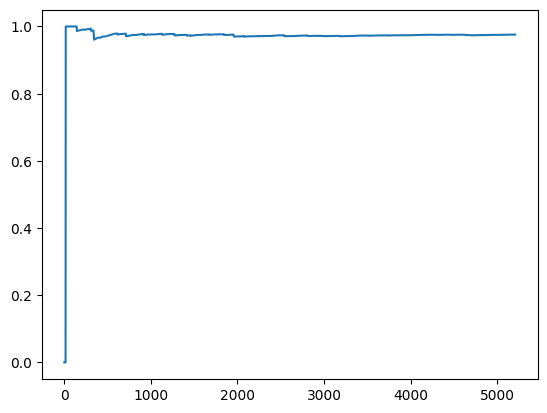

In [56]:
plt.plot(metric_list)

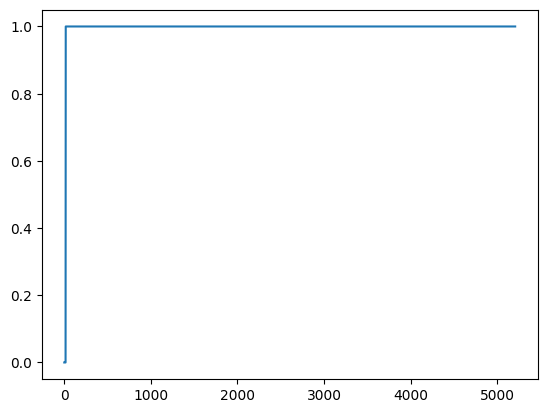

In [57]:
plt.plot(metric2_list)